In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

import scipy
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
from scipy.optimize import NonlinearConstraint
from scipy.optimize import SR1, BFGS
from scipy.optimize import minimize

import confound_mdp
import confound_ope
import confound_env

from core.sepsisSimDiabetes.State import State
from core.sepsisSimDiabetes.Action import Action
from core import generator_confounded_mdp as DGEN
from core import conf_wis as CWIS
from core import loss_minimization as LB
from utils.utils import *

import copy

In [2]:
## Below is David's code:
#account for sampling variance:
def fitted_q_update_reparam_sampling(f, pi_e, pihat, P_spsa, gam, R_sa, data, mdp):
    nStates = P_spsa.shape[0]
    nActions = P_spsa.shape[2]
    #gamma = mdp.gamma
    gamma = 1
    
    eps = 1 / np.sqrt(len(data))
    regression_data = np.array([[s, a, sp, gamma * (pi_e[int(sp),:] @ f[int(sp),:])] for s,a,u,sp,r in data])
    for i in regression_data:
        i[3] += R_sa[int(i[0]), int(i[1])] 

    next_state_sums = np.zeros((nStates, nStates, nActions))
    N_sa = np.zeros((nStates, nActions))
    for s,a,sp,y in regression_data:
        next_state_sums[(int(sp),int(s),int(a))] += y
        N_sa[int(s), int(a)] += 1
        
    f_hat = np.zeros((nStates, nActions))
    for s in range(nStates):
        for a in range(nActions):
            c = next_state_sums[:,s,a] #c
            lower = (pihat[s,a] + (1/gam)*(1-pihat[s,a]))
            upper = (gam + pihat[s,a]*(1-gam))
            bounds = [(lower, upper)]
            if N_sa[s,a] > 0: 
                c /= N_sa[s,a] #c
                f_hat[s,a] = scipy.optimize.linprog(c, A_eq=[P_spsa[:,s,a]], 
                                                 b_eq=[1], bounds=bounds).fun
            else:
                f_hat[s,a] = 0
    return f_hat

def fitted_q_update(f, pi_e, dataset, mdp):
    nStates = mdp.n_states
    nActions = mdp.n_actions
    data = dataset.reshape((dataset.shape[0]*dataset.shape[1],5))
    regression_data = np.array([[x, a, (pi_e[int(xp)] @ f[int(xp),:])] for x,a,u,xp,r in data])
    for i in regression_data:
        i[2] += R_sa[int(i[0]), int(i[1])] 
    Tf_hat = np.zeros((nStates, nActions))
    for x,a,y in regression_data:
        Tf_hat[int(x), int(a)] += y
    idx, count = np.unique(data[:,:2], axis=0, return_counts=True)
    for i,[x,a] in enumerate(idx):
        Tf_hat[int(x),int(a)] /= count[i]
    return Tf_hat

# Lower Bound Experiments

In [3]:
# want an evaluation policy that's better than the behavioral policy
# BUT with unobserved confounding the lower bound on the eval policy is worse than the behavioral policy
#    this is the scenario where the different sensitivity models matter in practice
#    e.g. for policy optimization

In [3]:
envs = []
# each row:
#   [mdp , pi_b, pi_e, horizon, gamma, nStates, nActions, term]

pi_b, P, R, x_dist, u_dist, gamma = confound_env.toyH2(0.6, 0.7, 0.8)

R = -1*R
toyH2 = confound_mdp.ConfoundMDP(P, R, x_dist, u_dist, gamma)
horizon = 5
nStates = P.shape[2]
nActions = P.shape[1]
pi_e = np.zeros((nStates, nActions))
for i in range(nStates):
    pi_e[i] = [0.3, 0.7]
    
envs.append([toyH2, pi_b, pi_e, horizon, gamma, nStates, nActions, -1, P, R, x_dist, u_dist, gamma])

pi_b, P, R, x_dist, u_dist, gamma = confound_env.toy227(0.25, 0.35)
toy = confound_mdp.ConfoundMDP(P, R, x_dist, u_dist, gamma)
horizon = 5
nStates = P.shape[2]
nActions = P.shape[1]
pi_e = np.zeros((nStates, nActions))
for i in range(nStates):
    pi_e[i] = [0.3, 0.7]
    
envs.append([toy, pi_b, pi_e, horizon, gamma, nStates, nActions, -1, P, R, x_dist, u_dist, gamma])

horizon = 4
graph_len = 4
pi_b, P, R, x_dist, u_dist, gamma = confound_env.graph_opetools(horizon=graph_len, slip=0.25, confound_weight=0.23)
R = -1*R
graph = confound_mdp.ConfoundMDP(P, R, x_dist, u_dist, gamma)
nStates = P.shape[2]
nActions = P.shape[1]

pi_e = np.zeros((nStates, nActions))
for i in range(nStates):
    pi_e[i] = [0.3, 0.7]
    
envs.append([graph, pi_b, pi_e, horizon, gamma, nStates, nActions, -1, P, R, x_dist, u_dist, gamma])

horizon = 10
pi_b, P, R, x_dist, u_dist, gamma = confound_env.toymc_opetools(n_left=8, n_right=8, horizon=20, slip=0.15, confound_weight=0.6)
#R = -1*R
toymc = confound_mdp.ConfoundMDP(P, R, x_dist, u_dist, gamma)

nStates = P.shape[2]
nActions = P.shape[1]

pi_e = np.zeros((nStates, nActions))
for i in range(nStates):
    pi_e[i] = [0.15, 0.85]
    
envs.append([toymc, pi_b, pi_e, horizon, gamma, nStates, nActions, -1, P, R, x_dist, u_dist, gamma])

horizon = 8
#, slip = 0.04, confound_weight=0.6
pi_b, P, R, x_dist, u_dist, gamma = confound_env.gridworld_opetools(horizon = horizon, slip = 0.04, confound_weight=0.6, small=True)
#R = -1*R
gridworld = confound_mdp.ConfoundMDP(P, R, x_dist, u_dist, gamma)

nStates = P.shape[2]
nActions = P.shape[1]

pi_e = np.zeros((nStates, nActions))
for i in range(nStates):
    pi_e[i] = [0.4, 0.1, 0.4, 0.1]
    
envs.append([gridworld, pi_b, pi_e, horizon, gamma, nStates, nActions, -1, P, R, x_dist, u_dist, gamma])

horizon = 8
#, slip = 0.04, confound_weight=0.6
pi_b, P, R, x_dist, u_dist, gamma = confound_env.gridworld_opetools(horizon = horizon, slip = 0.04, confound_weight=0.6, small=False)
#R = -1*R
gridworldLarge = confound_mdp.ConfoundMDP(P, R, x_dist, u_dist, gamma)

nStates = P.shape[2]
nActions = P.shape[1]

pi_e = np.zeros((nStates, nActions))
for i in range(nStates):
    pi_e[i] = [0.4, 0.1, 0.4, 0.1]
    
envs.append([gridworldLarge, pi_b, pi_e, horizon, gamma, nStates, nActions, -1, P, R, x_dist, u_dist, gamma])

horizon = 10
pi_b, P, R, x_dist, u_dist, gamma = confound_env.randwalk(pu1 = 1/6, pu2 = 1/2.5, pis1u1 = 1.0/4, pis2u1 = 1.0/6)
R = -1*R
randwalk = confound_mdp.ConfoundMDP(P, R, x_dist, u_dist, gamma)

nStates = P.shape[2]
nActions = P.shape[1]

pi_e = np.zeros((nStates, nActions))
for i in range(nStates):
    pi_e[i] = [0.3, 0.7]
    
envs.append([randwalk, pi_b, pi_e, horizon, gamma, nStates, nActions, -1, P, R, x_dist, u_dist, gamma])


In [10]:
fqe_envs = []
mb_envs = []

gams = [1.1, 1.5, 2, 3, 4, 6, 8, 10]
nGams = len(gams)

Pbs = [1.1, 1.5, 2, 3, 4, 6, 8, 10]
nPbs = len(Pbs)

#hadds = [0, 5, 10]
hadds = [0]

for mdp, pi_b, pi_e, base_horizon, gamma, nStates, nActions, term, P, R, x_dist, u_dist, gamma in envs:
    
    print("---")
    
    for h in hadds:
        horizon = base_horizon + h
        
        print("running env with horizon " + str(horizon))

        dataset = confound_mdp.collect_sample(int(30000/horizon), mdp, pi_b, horizon)
        data = dataset.reshape((dataset.shape[0]*dataset.shape[1],5))
        Phat = confound_ope.estimate_P(dataset, mdp)
        pihat = confound_ope.estimate_pi(dataset, mdp)
        for a in range(nActions):
            for s in range(nStates):
                if Phat[a,s].sum() == 0:
                    Phat[a,s,term] = 1
                if pihat[s].sum() == 0:
                    pihat[s,:] = 1/nActions
        pi_avg = pi_b[0] * u_dist[0] + pi_b[1] * u_dist[1]
        
        # This is the actual reward_sa
        # P(s,a,s') * R(s,a,s')
        # R(s,a) = \Sum_{s'} P(s,a,s') * R(s,a,s')
        R_sa = (np.average(P, axis=0, weights=u_dist) * R).sum(axis=2).T #np.sum(R, axis=2).T #.reshape(nStates, nActions)
        P_spsa = Phat.transpose((2, 1, 0))
        n = data.shape[0]
        Rhat_sa = (Phat * confound_ope.estimate_R(dataset, mdp)).sum(axis=2).T

         # behavior value
        print("value of pi_b")
        returns = confound_mdp.calc_returns(dataset, gamma, horizon)
        print(returns.mean())

        '''
        # no confounding:
        print("value of pi_e with no confounding")
        Q0 = np.zeros((nStates, nActions))
        nom_q = Q0.copy()
        for t in range(horizon):
            nom_q = fitted_q_update(nom_q, pi_e, dataset, mdp)
        print(mdp.get_value(nom_q,pi_e)[1])

        fqe_results = []

        print("now running C-FQE")
        for i,gam in enumerate(gams):
            Q0 = np.zeros((nStates, nActions))
            q_reparam_samp = Q0.copy()
            for t in range(horizon):
                q_reparam_samp = fitted_q_update_reparam_sampling(q_reparam_samp, pi_e, pihat, Pb_spsa, gam, R_sa, data, mdp)
            fqe_results.append(mdp.get_value(q_reparam_samp,pi_e)[0])
            
        '''

        '''
        print("now running robust mdps...")
        mb_results = np.zeros((nGams, nPbs))

        for i,gam in tqdm(enumerate(gams)):
            for j,P_bound in enumerate(Pbs):
                V0 = np.zeros(nStates)
                fixed_u_v = V0.copy()
                for t in range(horizon):
                    fixed_u_v = confound_ope.fixed_u_gp_s_rect(fixed_u_v, pi_e, 0.50, Phat, pihat, P_bound, gam, mdp)
                mb_results[i,j] = fixed_u_v @ mdp.x_dist

        fqe_envs.append(fqe_results)
        mb_envs.append(mb_results)
        '''

---
running env with horizon 5
value of pi_b
-2.9865552091999996
---
running env with horizon 5
value of pi_b
0.34285236914666667
---
running env with horizon 4
value of pi_b
-0.16731602026666667
---
running env with horizon 10
value of pi_b
-9.56179249911955
---
running env with horizon 8
value of pi_b
-0.5039925600411328
---
running env with horizon 8
value of pi_b
-0.3734135734356033
---
running env with horizon 10
value of pi_b
-14.713520541519134


In [11]:
from numba import njit
#Ptrue_spsa = np.einsum('u,uasp->psa', u_dist, P)
pi_bsa = np.einsum('u,usa->sa', u_dist, pi_b)
@njit
def getPb_spsa(nStates, nActions, u_dist, pi_b, pi_bsa, P):
    prob = np.zeros((nStates, nStates, nActions))
    for sp in range(nStates):
        for s in range(nStates):
            for a in range(nActions):
                for u in range(2):
                    prob[sp, s, a] += u_dist[u] * pi_b[u, s, a] * (1/pi_bsa[s,a]) * P[u, a, s, sp]
    return prob
Pb_spsa = getPb_spsa(nStates, nActions, u_dist, pi_b, pi_bsa, P)



In [12]:
def CFQE(f, pi_e, pi_bsa, Pb_spsa, gam, R_sa):
    nStates = Pb_spsa.shape[0]
    nActions = Pb_spsa.shape[2]
    f_hat = np.zeros((nStates, nActions))
    for s in range(nStates):
        for a in range(nActions):
            #c = pi_bsa[s,a]*np.array([R_sa[s,a] + np.dot(pi_e[sp,:], f[sp,:]) for sp in range(nStates)])
            c = np.array([Pb_spsa[sp,s,a]*(R_sa[s,a] + np.dot(pi_e[sp,:], f[sp,:])) for sp in range(nStates)])
            lower = (pi_bsa[s,a] + (1/gam)*(1-pi_bsa[s,a])),
            upper = (gam + pi_bsa[s,a]*(1-gam)),
            bounds = [lower, upper]
            f_hat[s,a] = scipy.optimize.linprog(c, A_eq = [Pb_spsa[:,s,a]],
                                                 b_eq = [1], bounds=bounds).fun
    return f_hat

# Here's where our work starts

So, here's what I think is going on. For the Gridworld problem, we have a 4x4 gridworld. 
`nStates` is 16, and `nActions` is 4. Of the things we're interested in, 
$$\mathbb{P} \in \mathbb{R}^{U \times A \times  S \times S'}, R \in \mathbb{R}^{A \times S \times S'}, \pi_b \in \mathbb{R}^{U \times S \times  A}, \pi_e \in \mathbb{R}^{S \times A}$$

`P` sums to 128. That, divided by `nStates` and then `nActions`, yields 2. I think then, that `P` gives the conditional transition probabilities given the selection of hidden state $U$.

`Phat` and `pihat` are estimates of the transition probabilities and behavior policy respectively with $U$ marginalized out. `Phat` sums to 64, and is given by the same calculation method of $N(s, a, s')/N(s, a)$ as $\hat{\mathbb{P}}_{\pi_b}(s' | s, a)$, so we can conclude that it is that. Permuting axes to be ordered (s', s, a) gives us `P_spsa`. Additionally, `pihat[a, s]` really gives $\hat{\pi_b}(a | s)$. 

Define `R_sa` to be the array of rewards for each state-action pair. David sets `R[:, i, :]` to be a flattened copy of the grid. That's not really what we're interested in, but we can average the transition probabilities among the distribution of u, take the element-wise product with the `R` array, sum it over the $S'$ axis and take the transpose to obtain `R_sa`.

Actions are indexed WENS

In [ ]:
# This is the estimated reward(s, a)
#R_sa = (Phat * confound_ope.estimate_R(dataset, mdp)).sum(axis=2).T
#R_sa
#N_sa

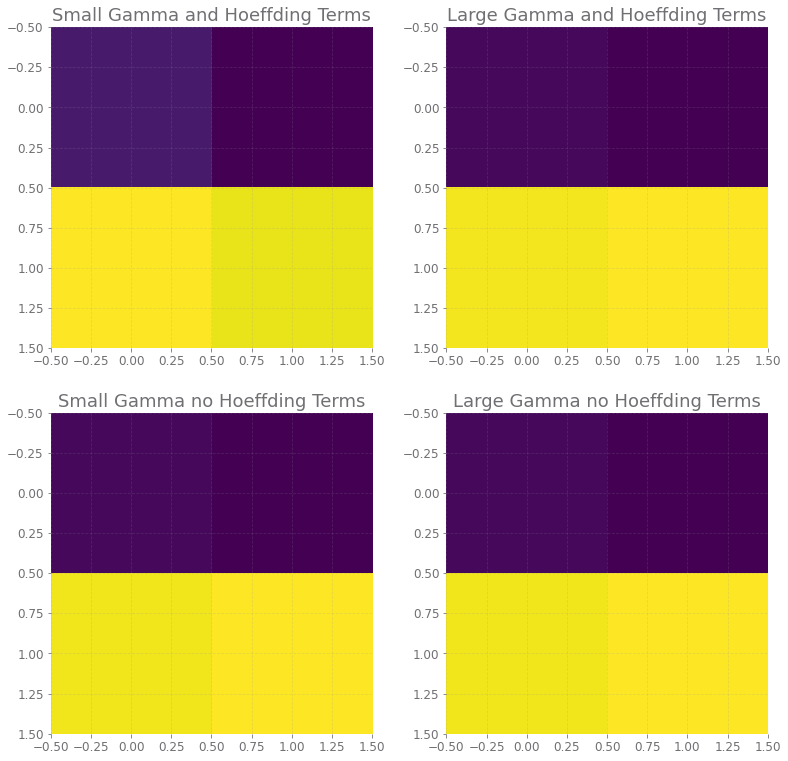

In [13]:
N_sa = np.zeros((nStates, nActions))
for s,a,u,sp,r in data:
    N_sa[int(s),int(a)] += 1

def getBounds(gam, delta, pi_bsa, Pb_spsa, N_sa, hoeffding=False):
    nStates = N_sa.shape[0]
    nActions = N_sa.shape[1]
    alpha_sa = pi_bsa + (1/gam) * (1-pi_bsa)
    beta_sa = gam + pi_bsa*(1-gam)
    if hoeffding:
        nStates = N_sa.shape[0]
        nActions = N_sa.shape[1]
        G_lb = alpha_sa[np.newaxis,:,:]*(Pb_spsa - np.sqrt(np.reciprocal(2*N_sa.astype(float)) * np.log((2*n*(nStates**2)*nActions)/delta)))
        G_ub = beta_sa[np.newaxis,:,:]*(Pb_spsa + np.sqrt(np.reciprocal(2*N_sa.astype(float)) * np.log((2*n*(nStates**2)*nActions)/delta)))
        return G_lb, G_ub
    else:
        return alpha_sa[np.newaxis,:,:]*Pb_spsa, beta_sa[np.newaxis,:,:]*Pb_spsa

G_lb, G_ub = getBounds(gams[-1], 0.05, pi_bsa, Pb_spsa, N_sa, hoeffding=True)
vmin=np.min(G_ub-G_lb)
vmax=np.max(G_ub-G_lb)
action = 0
fig, axs = plt.subplots(2, 2, figsize=(13,13))
G_lb, G_ub = getBounds(gams[0], 0.05, pi_bsa, Pb_spsa, N_sa, hoeffding=True)
axs[0, 0].imshow((G_ub - G_lb)[:,:,action], vmin=vmin, vmax=vmax)
axs[0, 0].imshow((G_ub - G_lb)[:,:,action])
axs[0, 0].set_title('Small Gamma and Hoeffding Terms')
G_lb, G_ub = getBounds(gams[-1], 0.05, pi_bsa, Pb_spsa, N_sa, hoeffding=True)
axs[0, 1].imshow((G_ub - G_lb)[:,:,action], vmin=vmin, vmax=vmax)
axs[0, 1].imshow((G_ub - G_lb)[:,:,action])
axs[0, 1].set_title('Large Gamma and Hoeffding Terms')
G_lb, G_ub = getBounds(gams[0], 0.05, pi_bsa, Pb_spsa, N_sa, hoeffding=False)
smallGam = (G_ub - G_lb)[:,:,action]
axs[1, 0].imshow((G_ub - G_lb)[:,:,action], vmin=vmin, vmax=vmax)
axs[1, 0].imshow((G_ub - G_lb)[:,:,action])
axs[1, 0].set_title('Small Gamma no Hoeffding Terms')
G_lb, G_ub = getBounds(gams[-1], 0.05, pi_bsa, Pb_spsa, N_sa, hoeffding=False)
largeGam = (G_ub - G_lb)[:,:,action]
axs[1, 1].imshow((G_ub - G_lb)[:,:,action], vmin=vmin, vmax=vmax)
axs[1, 1].imshow((G_ub - G_lb)[:,:,action])
axs[1, 1].set_title('Large Gamma no Hoeffding Terms')

plt.savefig('HoeffdingCompare.png')

G_lb = alpha_sa[np.newaxis,:,:]*(Pb_spsa - np.sqrt(np.reciprocal(2*N_sa.astype(float)) * np.log((2*n*(nStates**2)*nActions)/delta)))
G_ub = beta_sa[np.newaxis,:,:]*(Pb_spsa + np.sqrt(np.reciprocal(2*N_sa.astype(float)) * np.log((2*n*(nStates**2)*nActions)/delta)))
plt.imshow((G_ub - G_lb)[:,:,0])

In [14]:
import gurobipy as gp
from gurobipy import GRB
import time


def softtime(model, where):
    softlimit = 30
    if where == GRB.Callback.MIP:
        runtime = model.cbGet(GRB.Callback.RUNTIME)
        objbst = model.cbGet(GRB.Callback.MIP_OBJBST)
        objbnd = model.cbGet(GRB.Callback.MIP_OBJBND)
        gap = abs((objbst - objbnd) / objbst)

        if runtime > softlimit and gap < 0.5:
            model.terminate()
            
def cb(model, where):
    if where == GRB.Callback.MIPNODE:
        # Get model objective
        obj = model.cbGet(GRB.Callback.MIPNODE_OBJBST)

        # Has objective changed?
        if abs(obj - model._cur_obj) > 1e-8:
            # If so, update incumbent and time
            model._cur_obj = obj
            model._time = time.time()

    # Terminate if objective has not improved in 20s
    if time.time() - model._time > 20:
        model.terminate()

def mbrlLoop(horizon, R_sa, N_sa, Pb_spsa, pi_bsa, pi_e, gams, so=0, lb=None, ub=None):
    objVals = []
    if lb is None:
        lb = -10*np.ones(len(gams))
    if ub is None:
        ub = np.ones(len(gams))
    
    for idx, gam in enumerate(gams):
        alpha_sa = pi_bsa + (1/gam) * (1-pi_bsa)
        beta_sa = gam + pi_bsa*(1-gam)
        #G_lb = alpha_sa[np.newaxis,:,:]*(Pb_spsa - 
        #                                 np.sqrt(np.reciprocal(2*N_sa.astype(float)) * 
        #                                np.log((2*n*(nStates**2)*nActions)/delta)))
        #G_ub = beta_sa[np.newaxis,:,:]*(Pb_spsa + 
        #                                np.sqrt(np.reciprocal(2*N_sa.astype(float)) * 
        #                                np.log((2*n*(nStates**2)*nActions)/delta)))
        G_lb = alpha_sa[np.newaxis,:,:]*(Pb_spsa)
        G_ub = beta_sa[np.newaxis,:,:]*(Pb_spsa)
        m = gp.Model('bilinear')
        m.setParam('NonConvex', 2)
        m.setParam('Presolve', 1)
        #m.setParam('Aggregate', 0)
        #m.setParam('NumericFocus', 3)
        #m.setParam('BarHomogeneous', 1)
        #m.setParam('BarCorrectors', 1000)
        #m.setParam('OptimalityTol', 1e-7)
        #m.setParam('FeasibilityTol', 1e-7)
        #m.setParam('BarConvTol', 1e-7)
        #m.setParam('BarQCPConvTol', 1e-7)
        #m.setParam('MIPFocus', 1)
        #m.setParam("OutputFlag", 0)
        #m.setParam('Method', 2)

        # V_2, ... , V_H <=> [0, ..., H-1), H-1 x S sized
        V = m.addVars(horizon, nStates, lb=lb[idx], ub=ub[idx], vtype=GRB.CONTINUOUS) 
        Prob_spsa = m.addVars(nStates, nStates, nActions, lb=0, ub=1, vtype=GRB.CONTINUOUS)

        m.update()
        
        # Prob matrix membership constraint
        for sp in range(nStates):
            for s in range(nStates):
                for a in range(nActions):
                    m.addConstr(Prob_spsa[sp, s, a] >= float(G_lb[sp, s, a]))
                    m.addConstr(Prob_spsa[sp, s, a] <= float(G_ub[sp, s, a]))

        # Prob matrix row sum constraint
        for s in range(nStates):
            for a in range(nActions):
                m.addConstr(gp.quicksum(Prob_spsa[sp, s, a] 
                                         for sp in range(nStates)) == 1)

        for s in range(nStates):
            m.addConstr(V[horizon-1, s] == 0)
            
        #for h in range(horizon):
        #    m.addConstr(V[h, 15] == 0)

        # Bellman Backup constraints: H-1 x S ordinary constraints for h = 2,...,H
        for h in range(horizon-1):
            for s in range(nStates):
                m.addConstr(V[h, s] == (gp.quicksum(pi_e[s, a]*R_sa[s, a]
                                                    for a in range(nActions)) + 
                                       gp.quicksum(pi_e[s, a]*Prob_spsa[sp,s,a]*V[h+1,sp] 
                                                    for a in range(nActions) 
                                                    for sp in range(nStates))))
        
        # Directly maximize the quadratic form for V_1(s0). 
        # Substitute so for what we previously called s. 
        # We need V_2(\cdot) in the RHS, so as before subtract 2 and take V[0, sp]
        obj = (gp.quicksum(pi_e[so, a]*R_sa[so, a] 
                            for a in range(nActions)) + 
                gp.quicksum(pi_e[so, a]*Prob_spsa[sp,so,a]*V[0,sp] 
                            for a in range(nActions) 
                            for sp in range(nStates)))
        
        
        m.setObjective(obj, GRB.MINIMIZE)
        m._cur_obj = float('inf')
        m._time = time.time()

        m.optimize(cb)
        #m.optimize()
        try:
            objVals.append(m.objVal)
        except:
            objVals.append(float('inf'))
    return objVals

In [15]:
# min \forall h \forall s
def mbrlRelax(horizon, R_sa, N_sa, Pb_spsa, pi_bsa, pi_e, gams, prob=False):
    nStates = N_sa.shape[0]
    nActions = N_sa.shape[1]
    Vgams = []
    #for gam in [gams[-1]]:
    for gam in gams:
        V = np.zeros((horizon+1, nStates))
        for h in reversed(range(horizon)):
            alpha_sa = pi_bsa + (1/gam) * (1-pi_bsa)
            beta_sa = gam + pi_bsa*(1-gam)
            #G_lb = alpha_sa[np.newaxis,:,:]*(Pb_spsa - 
            #                                 np.sqrt(np.reciprocal(2*N_sa.astype(float)) * 
            #                                np.log((2*n*(nStates**2)*nActions)/delta)))
            #G_ub = beta_sa[np.newaxis,:,:]*(Pb_spsa + 
            #                                np.sqrt(np.reciprocal(2*N_sa.astype(float)) * 
            #                                np.log((2*n*(nStates**2)*nActions)/delta)))
            G_lb = alpha_sa[np.newaxis,:,:]*(Pb_spsa)
            G_ub = beta_sa[np.newaxis,:,:]*(Pb_spsa)
            for so in range(nStates):
            #for so in range(1):
                m = gp.Model()
                m.setParam("OutputFlag", 0)
                #m.setParam('Presolve', 0)

                Prob_spsa = m.addVars(nStates, nStates, nActions, lb=0, ub=1, vtype=GRB.CONTINUOUS)

                # Prob matrix membership constraint
                for sp in range(nStates):
                    for s in range(nStates):
                        for a in range(nActions):
                            m.addConstr(Prob_spsa[sp, s, a] >= float(G_lb[sp, s, a]))
                            m.addConstr(Prob_spsa[sp, s, a] <= float(G_ub[sp, s, a]))

                # Prob matrix row sum constraint
                for s in range(nStates):
                    for a in range(nActions):
                        m.addConstr(gp.quicksum(Prob_spsa[sp, s, a] 
                                                 for sp in range(nStates)) == 1)

                # Substitute so for what we previously called s. 
                obj = (gp.quicksum(pi_e[so, a]*R_sa[so, a] 
                                    for a in range(nActions)) + 
                        gp.quicksum(pi_e[so, a]*Prob_spsa[sp,so,a]*V[h+1, sp]
                                    for a in range(nActions) 
                                    for sp in range(nStates)))

                m.setObjective(obj, GRB.MINIMIZE)

                m.optimize()

                V[h, so] = m.objVal
        Vgams.append(V[0,:])
        #for h in reversed(range(horizon)):
        #    print(V[h,:])
    #return np.array(Vgams)
    if prob:
        Prob_ret = np.zeros((nStates, nStates, nActions))
        for sp in range(nStates):
            for s in range(nStates):
                for a in range(nActions):
                    Prob_ret[sp,s,a] = Prob_spsa[sp,s,a].x
        return Prob_ret
    else:
        return np.array(Vgams)

Prob_ret = mbrlRelax(horizon, R_sa, N_sa, Pb_spsa, pi_bsa, pi_e, prob=True)
recursiveV(0,0,pi_e,R_sa,Pb_spsa)

In [10]:
#relaxResults = mbrlRelax(horizon, R_sa, N_sa, Pb_spsa, pi_bsa, pi_e, gams)
relaxResults = mbrlRelax(horizon, Rhat_sa, N_sa, P_spsa, pi_bsa, pi_e, gams)

Set parameter Username
Academic license - for non-commercial use only - expires 2022-04-27


In [ ]:
#objVals = [mbrlLoop(horizon, Rhat_sa, N_sa, P_spsa, pi_bsa, pi_e, gams, so) for so in range(nStates)]
objVals = [mbrlLoop(horizon, Rhat_sa, N_sa, P_spsa, pi_bsa, pi_e, gams, so, lb=relaxResults[:,so]-0.5) for so in range(1)]
#objVals = [mbrlLoop(horizon, R_sa, N_sa, Pb_spsa, pi_bsa, pi_e, gams, so) for so in range(nStates)]
#objVals = [mbrlLoop(horizon, R_sa, N_sa, Pb_spsa, pi_bsa, pi_e, gams, so) for so in range(1)]

In [60]:
#pd.DataFrame(objVals).T.to_csv("GridworldSampleExact.csv")

In [ ]:
relaxResults[:,0]

In [39]:
objVals = pd.read_csv('GridworldExact.csv').to_numpy().T

In [ ]:
objVals

In [16]:
V = np.zeros((horizon+1, nStates))
def recursiveV(h, s, pi_e, R_sa, Pb_spsa):
    if h == horizon:
        return 0
    elif V[h,s] != 0:
        return V[h,s]
    else:
        Vhp = np.array([recursiveV(h+1,sp, pi_e, R_sa, Pb_spsa) for sp in range(nStates)])
        V[h+1,:] = Vhp
        return pi_e[s,:].T @ (R_sa[s,:] + Pb_spsa[:,s,:].T @ Vhp)
V = np.zeros((horizon+1, nStates))
recursiveV(0, 0, pi_e, R_sa, Pb_spsa)

-14.066666666666666

## Neural Nets for Computing Value Lower Bound

In [17]:

import torch
from torch.cuda.amp import custom_bwd, custom_fwd
from torch import nn


class DifferentiableClamp(torch.autograd.Function):
    """
    In the forward pass this operation behaves like torch.clamp.
    But in the backward pass its gradient is 1 everywhere, as if instead of clamp one had used the identity function.
    """

    @staticmethod
    @custom_fwd
    def forward(ctx, input, min, max):
        return input.clamp(min=min, max=max)
        #return torch.max(torch.min(input, max), min)

    @staticmethod
    @custom_bwd
    def backward(ctx, grad_output):
        return grad_output.clone(), None, None


def dclamp(input, min, max):
    """
    Like torch.clamp, but with a constant 1-gradient.
    :param input: The input that is to be clamped.
    :param min: The minimum value of the output.
    :param max: The maximum value of the output.
    """
    return DifferentiableClamp.apply(input, min, max)

In [18]:
class ValueEstimator(nn.Module):
    def __init__(self, nStates, nActions, horizon, pi_e, R_sa, Pb_spsa, lb, ub, so=0):
        super(ValueEstimator, self).__init__()
        Pcopy = copy.deepcopy(Pb_spsa)
        self.nStates = nStates
        self.nActions = nActions
        self.horizon = horizon
        self.so = so
        self.pi_e = torch.from_numpy(copy.deepcopy(pi_e))
        self.R_sa = torch.from_numpy(copy.deepcopy(R_sa))
        self.lb = torch.from_numpy(copy.deepcopy(lb))
        self.ub = torch.from_numpy(copy.deepcopy(ub))
        
        self.pi_e,self.R_sa=self.pi_e.type(torch.DoubleTensor),self.R_sa.type(torch.DoubleTensor)
        self.lb,self.ub=self.lb.type(torch.DoubleTensor),self.ub.type(torch.DoubleTensor)
        self.P = nn.ParameterList([nn.Parameter(torch.from_numpy(copy.deepcopy(Pcopy[:,s,:])), 
                                                requires_grad=True) for s in range(nStates)])

    def forward(self):
        # ParameterList can act as an iterable, or be indexed using ints
        Vhp = torch.zeros(self.nStates).type(torch.DoubleTensor)
        # Bellman Backup constraints: H-1 x S ordinary constraints for h = 2,...,H
        for h in range(self.horizon-1):
            Vhp = torch.stack([self.pi_e[s,:].T @ (self.R_sa[s,:] + self.P[s].T @ Vhp) 
                               for s in range(nStates)])
            for s in range(self.nStates):
                self.P[s].data = self.P[s].data / torch.sum(self.P[s].data, dim=0)
                self.P[s].data = dclamp(self.P[s].data, self.lb[:,s,:], self.ub[:,s,:])
        return self.pi_e[self.so,:].T @ (self.R_sa[self.so,:] + self.P[self.so].T @ Vhp)
    
    

In [37]:
V = np.zeros((horizon+1, nStates))
recursiveV(0, 0, pi_e, R_sa, Pb_spsa)

NameError: name 'recursiveV' is not defined

In [19]:
def getTorchVals(horizon, R_sa, N_sa, Pb_spsa, pi_bsa, pi_e, gams, so=0):
    nStates = N_sa.shape[0]
    nActions = N_sa.shape[1]
    torchLoss = []
    for gam in gams:
        G_lb, G_ub = getBounds(gam, 0.05, pi_bsa, Pb_spsa, N_sa, hoeffding=False)
        valEst = ValueEstimator(nStates, nActions, horizon, pi_e, R_sa, Pb_spsa, G_lb, G_ub, so)
        optimizer = torch.optim.SGD(valEst.parameters(), lr=5e-3, momentum=0.9)

        oldloss = float('inf')
        for t in range(3000):
            # Forward pass: Compute predicted V
            V_pred = valEst()

            # Compute and print loss
            loss = V_pred
            if t % 100 == 0:
                print(t, loss)
                #print(valEst.P[0])

            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            loss.backward()
            #torch.nn.utils.clip_grad_norm_(valEst.parameters(), 1)
            optimizer.step()
            if torch.abs(loss - oldloss) < 1e-5:
                break
            oldloss = loss if t % 10 == 0 else oldloss
        torchLoss.append(valEst().detach().item())
    return torchLoss

In [95]:
torchVals = [getTorchVals(horizon, R_sa, N_sa, Pb_spsa, pi_bsa, pi_e, gams, so) for so in range(nStates)]

0 tensor(3.1000, dtype=torch.float64, grad_fn=<DotBackward0>)
0 tensor(3.1000, dtype=torch.float64, grad_fn=<DotBackward0>)
0 tensor(3.1000, dtype=torch.float64, grad_fn=<DotBackward0>)
0 tensor(3.1000, dtype=torch.float64, grad_fn=<DotBackward0>)
0 tensor(3.1000, dtype=torch.float64, grad_fn=<DotBackward0>)
0 tensor(3.1000, dtype=torch.float64, grad_fn=<DotBackward0>)
0 tensor(3.1000, dtype=torch.float64, grad_fn=<DotBackward0>)
0 tensor(3.1000, dtype=torch.float64, grad_fn=<DotBackward0>)
0 tensor(3.1000, dtype=torch.float64, grad_fn=<DotBackward0>)
0 tensor(3.1000, dtype=torch.float64, grad_fn=<DotBackward0>)
0 tensor(3.1000, dtype=torch.float64, grad_fn=<DotBackward0>)
0 tensor(3.1000, dtype=torch.float64, grad_fn=<DotBackward0>)
0 tensor(3.1000, dtype=torch.float64, grad_fn=<DotBackward0>)
0 tensor(3.1000, dtype=torch.float64, grad_fn=<DotBackward0>)
0 tensor(3.1000, dtype=torch.float64, grad_fn=<DotBackward0>)
0 tensor(3.1000, dtype=torch.float64, grad_fn=<DotBackward0>)


In [40]:
#pd.DataFrame(torchVals).T.to_csv("torchNotExact.csv")
torchVals = pd.read_csv('torchNotExact.csv').to_numpy().T

P_pred = np.transpose(np.array([np.array(valEst.P[s].data) for s in range(nStates)]), [1,0,2])
print(np.all([G_lb <= Pb_spsa, Pb_spsa <= G_ub]))
print(np.all([G_lb <= P_pred, P_pred <= G_ub]))
V = np.zeros((horizon+1, nStates))
recursiveV(0, 0, pi_e, R_sa, P_pred)

In [20]:
def fitted_q_update(f, pi_e, dataset, mdp):
    nStates = mdp.n_states
    nActions = mdp.n_actions
    data = dataset.reshape((dataset.shape[0]*dataset.shape[1],5))
    regression_data = np.array([[x, a, r + mdp.gamma * (pi_e[int(xp)] @ f[int(xp),:])] for x,a,u,xp,r in data])
    Tf_hat = np.zeros((nStates, nActions))
    for x,a,y in regression_data:
        Tf_hat[int(x), int(a)] += y
    idx, count = np.unique(data[:,:2], axis=0, return_counts=True)
    for i,[x,a] in enumerate(idx):
        Tf_hat[int(x),int(a)] /= count[i]
    return Tf_hat

def fitted_q_evaluation(pi_e, dataset, horizon, mdp):
    Qhat = np.zeros((mdp.n_states, mdp.n_actions))
    for k in tqdm(range(horizon)):
        newQ = fitted_q_update(Qhat, pi_e, dataset, mdp)
        #trueNewQ = bellman_eval_update(Qhat, np.array([pi_e,pi_e]))
        #print("Squared error: " + str(((newQ - trueNewQ)**2).sum()))
        Qhat = newQ
    return Qhat



In [30]:
reg_fqe_results = []
print("now running FQE")
for i,gam in enumerate(gams):
    Q0 = np.zeros((nStates, nActions))
    nom_q = Q0.copy()
    for t in range(horizon):
        nom_q = CFQE(nom_q, pi_e, pi_bsa, Pb_spsa, 1, R_sa,)
    reg_fqe_results.append(mdp.get_value(nom_q,pi_e)[0])

now running FQE


In [66]:
fqe_results = []
print("now running C-FQE")
for i,gam in enumerate(gams):
    Q0 = np.zeros((nStates, nActions))
    q_reparam_samp = Q0.copy()
    for t in range(horizon):
        q_reparam_samp = fitted_q_update_reparam_sampling(q_reparam_samp, pi_e, pi_bsa, P_spsa, gam, Rhat_sa, data, mdp)
        #q_reparam_samp = fitted_q_update_reparam_sampling(q_reparam_samp, pi_e, pi_bsa, Pb_spsa, gam, R_sa, data, mdp)
    fqe_results.append(mdp.get_value(q_reparam_samp,pi_e)[0])

now running C-FQE


In [64]:
cfqe_results = []
for gam in gams: 
    Q0 = np.zeros((nStates, nActions))
    cfqe = Q0.copy()
    for t in range(horizon):
        #cfqe = CFQE(cfqe, pi_e, pi_bsa, Pb_spsa, gam, R_sa)
        cfqe = CFQE(cfqe, pi_e, pi_bsa, P_spsa, gam, Rhat_sa)
    cfqe_results.append(mdp.get_value(cfqe,pi_e)[0])

In [21]:
def calc_returns(data, gamma, horizon):
    rewards = data[:,:,-1]
    g = np.array([gamma**t for t in range(horizon)])
    return (rewards * g).sum(axis=1)

def get_value(self, Q, pi):
    V = np.array([Q[x] @ pi[x] for x in range(self.n_states)])
    avgV = V @ self.x_dist
    return V, avgV

States 0, 2, 3 (barely), 7, 9 are the most favorable to us. MBGrad struggles with 12, 13, 14.

In [45]:
objVals

[[-0.20540087779052502,
  -0.25901011980269906,
  -0.3107656869397537,
  -0.38923229273941423,
  -0.4531886318085846,
  -0.5513670298419537,
  -0.6015544147285473,
  -0.6254534368301983]]

In [19]:
reg_fqe_results

[array([-1.14682477, -1.23245614, -1.2039125 , -1.22999387, -1.23473691,
        -1.44220779, -1.41927844, -1.36595584, -1.4661163 , -1.49615904,
        -1.53550595, -0.93449281, -1.85880638, -1.63810031, -0.99386043,
         0.        ]),
 array([-1.14682477, -1.23245614, -1.2039125 , -1.22999387, -1.23473691,
        -1.44220779, -1.41927844, -1.36595584, -1.4661163 , -1.49615904,
        -1.53550595, -0.93449281, -1.85880638, -1.63810031, -0.99386043,
         0.        ]),
 array([-1.14682477, -1.23245614, -1.2039125 , -1.22999387, -1.23473691,
        -1.44220779, -1.41927844, -1.36595584, -1.4661163 , -1.49615904,
        -1.53550595, -0.93449281, -1.85880638, -1.63810031, -0.99386043,
         0.        ]),
 array([-1.14682477, -1.23245614, -1.2039125 , -1.22999387, -1.23473691,
        -1.44220779, -1.41927844, -1.36595584, -1.4661163 , -1.49615904,
        -1.53550595, -0.93449281, -1.85880638, -1.63810031, -0.99386043,
         0.        ]),
 array([-1.14682477, -1.23245614

In [20]:
cfqe_results

[array([-1.27050278, -1.35931397, -1.31579369, -1.33234138, -1.36745993,
        -1.57331479, -1.5474197 , -1.47609053, -1.61553311, -1.63760366,
        -1.67543031, -1.0413168 , -2.02238465, -1.80167969, -1.13006601,
         0.        ]),
 array([-1.73258634, -1.82908471, -1.73763076, -1.71826022, -1.8609278 ,
        -2.05688206, -2.01985776, -1.89070984, -2.15253672, -2.14562121,
        -2.1764493 , -1.44374705, -2.57498022, -2.36196645, -1.61688729,
         0.        ]),
 array([-2.18989764, -2.28701333, -2.16605142, -2.11785725, -2.34390498,
        -2.52302268, -2.47734062, -2.31175843, -2.65465219, -2.61818808,
        -2.64309749, -1.85493541, -3.05129691, -2.85195947, -2.06916771,
         0.        ]),
 array([-2.72970317, -2.82750679, -2.69651738, -2.62865577, -2.90201441,
        -3.06218184, -3.01707185, -2.84398935, -3.20965938, -3.15293503,
        -3.18122486, -2.3906407 , -3.55972553, -3.38809173, -2.60667962,
         0.        ]),
 array([-3.06957944, -3.16630308

In [21]:
fqe_results

[array([-1.36116129, -1.45673843, -1.39295056, -1.40114478, -1.45792705,
        -1.66815692, -1.62445751, -1.51762278, -1.71202548, -1.74020623,
        -1.76381437, -1.02544657, -2.15115513, -1.91433053, -1.19169116,
         0.        ]),
 array([-2.07467868, -2.22138965, -2.15464476, -2.14042549, -2.20120582,
        -2.44704141, -2.39618131, -2.33484423, -2.51510525, -2.56190617,
        -2.57545351, -1.72313149, -3.02692332, -2.78265943, -1.9120841 ,
         0.        ]),
 array([-2.89051723, -3.12358475, -3.12700725, -3.1333866 , -3.04136984,
        -3.36009944, -3.32275585, -3.46123295, -3.37256572, -3.49555729,
        -3.52348296, -2.67225055, -3.9102086 , -3.67538638, -2.69915609,
         0.        ]),
 array([-4.17495935, -4.69981545, -5.0380561 , -5.26957145, -4.31504329,
        -4.91440429, -5.07577133, -6.01496684, -4.6079542 , -5.03563996,
        -5.20290229, -4.72242882, -5.09320072, -4.91436778, -3.88411502,
         0.        ]),
 array([ -5.60590716,  -6.698049

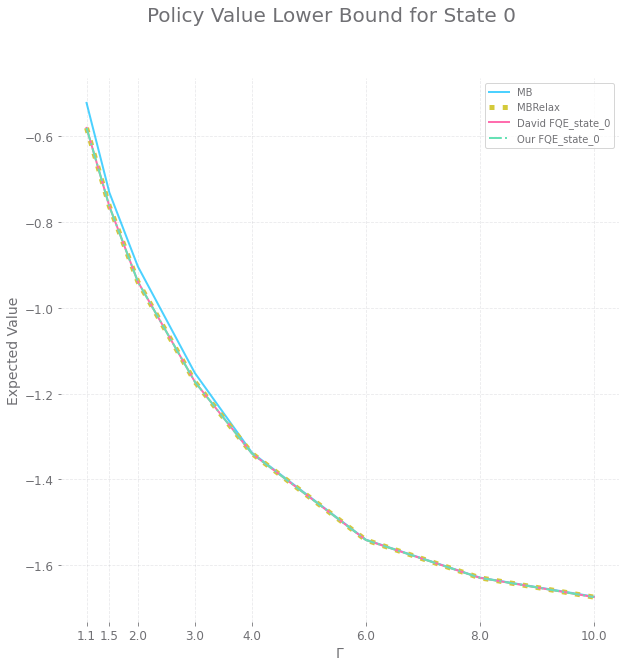

In [71]:
so = 0

# fix this to not be sample dependent
#wait, this is nonsense. This average is not state dependent!
#returns = confound_mdp.calc_returns(dataset, gamma, horizon)
#pi_b_val = returns.mean()

# fix this to use our non sample dependent FQE
#Q0 = np.zeros((nStates, nActions))
#nom_q = Q0.copy()
#for t in range(horizon):
#    nom_q = fitted_q_update(nom_q, pi_e, dataset, mdp)
#pi_b_val = mdp.get_value(nom_q,pi_bsa)[0][so]
#pi_e_val = mdp.get_value(nom_q,pi_e)[0][so]

for so in range(so, so+1): #nStates

    fig, ax = plt.subplots(figsize=(10,10))
    #change this to R_sa form
    #ax.axhline(pi_e_val, color='green', linestyle='--', label='pi_e_no_cf_state_' + str(so))
    #ax.axhline(pi_b_val, color='red', linestyle='--', label='pi_b')
    ax.set_xticks(gams)
    ax.set_xlabel('$\Gamma$')
    ax.set_ylabel('Expected Value')
    fig.suptitle("Policy Value Lower Bound for State " + str(so), size=20)

    ax.plot(gams, objVals[so], label='MB', alpha=0.7)
    ax.plot(gams, relaxResults[:,so], label='MBRelax', linewidth=5.0, linestyle='dotted')
    ax.plot(gams, np.array(fqe_results)[:,so], label='David FQE_state_'+str(so))
    #ax.plot(gams, torchVals[so], label='MBGrad', alpha=0.7)
    ax.plot(gams, np.array(cfqe_results)[:,so], label='Our FQE_state_'+str(so), linestyle='dashdot')

    ax.legend()
plt.savefig("ohdear.jpg")

In [ ]:
np.array([np.array(valEst.P[s].data) for s in range(nStates)]).sum(axis=1)

class ValueEstimator(nn.Module):
    def __init__(self, input_size, nStates, nActions, horizon, learning_rate=0.01, optimizer=optim.Adam):
        super().__init__()

        self.layers = nn.ModuleList()
        self.input_size = input_size  # Can be useful later ...
        
        #H+1,...,2,1 <=> H,..,1,0 <=> H layers, H+1 if including V1
        #feed in zeros to H+1
        for i in range(horizon):
            self.layers.append(nn.Linear(nStates, nStates))

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)
        self.learning_rate = learning_rate
        self.optimizer = optimizer(params=self.parameters(), lr=learning_rate)

    def forward(self, input_data):
        for layer in self.layers:
            input_data = layer(input_data)
        return input_data


if __name__ == "__main__":
    """
    Tests
    """
    data_size = 5
    layer1, layer2 = 10, 10
    output_size = 2
    data = torch.randn(data_size)
    mlp = MLP(data_size, [(layer1, nn.ReLU()), (layer2, nn.ReLU()), (output_size, nn.Sigmoid())])
    output = mlp(data)
    print("done")

In [ ]:
relaxEnvs = []
objEnvs = []
torchEnvs = []
cfqeEnvs = []
fqeEnvs = []

gams = [1.1, 1.5, 2, 3, 4, 6, 8, 10]
nGams = len(gams)

Pbs = [1.1, 1.5, 2, 3, 4, 6, 8, 10]
nPbs = len(Pbs)

#hadds = [0, 5, 10]
hadds = [0]


envNo = 0
for mdp, pi_b, pi_e, base_horizon, gamma, nStates, nActions, term, P, R, x_dist, u_dist, gamma in envs:
    
    print("---")
    
    for h in hadds:
        horizon = base_horizon + h
        
        print("running env with horizon " + str(horizon))

        dataset = confound_mdp.collect_sample(int(30000/horizon), mdp, pi_b, horizon)
        data = dataset.reshape((dataset.shape[0]*dataset.shape[1],5))
        Phat = confound_ope.estimate_P(dataset, mdp)
        pihat = confound_ope.estimate_pi(dataset, mdp)
        for a in range(nActions):
            for s in range(nStates):
                if Phat[a,s].sum() == 0:
                    Phat[a,s,term] = 1
                if pihat[s].sum() == 0:
                    pihat[s,:] = 1/nActions
        pi_avg = pi_b[0] * u_dist[0] + pi_b[1] * u_dist[1]
        
        # This is the actual reward_sa
        # P(s,a,s') * R(s,a,s')
        # R(s,a) = \Sum_{s'} P(s,a,s') * R(s,a,s')
        R_sa = (np.average(P, axis=0, weights=u_dist) * R).sum(axis=2).T #np.sum(R, axis=2).T #.reshape(nStates, nActions)
        P_spsa = Phat.transpose((2, 1, 0))
        n = data.shape[0]
        
        Rhat_sa = (Phat * confound_ope.estimate_R(dataset, mdp)).sum(axis=2).T

         # behavior value
        print("value of pi_b")
        returns = confound_mdp.calc_returns(dataset, gamma, horizon)
        print(returns.mean())
        
        pi_bsa = np.einsum('u,usa->sa', u_dist, pi_b)

        Pb_spsa = getPb_spsa(nStates, nActions, u_dist, pi_b, pi_bsa, P)
        N_sa = np.zeros((nStates, nActions))
        for s,a,u,sp,r in data:
            N_sa[int(s),int(a)] += 1
            
        print('fqe and cfqe')
        fqe_results = []
        cfqe_results = []
        for gam in gams: 
            Q0 = np.zeros((nStates, nActions))
            cfqe = Q0.copy()
            for t in range(horizon):
                #cfqe = CFQE(cfqe, pi_e, pi_bsa, Pb_spsa, gam, R_sa)
                #fqe = CFQE(cfqe, pi_e, pi_bsa, Pb_spsa, 1, R_sa)
                cfqe = CFQE(cfqe, pi_e, pi_bsa, P_spsa, gam, Rhat_sa)
                fqe = CFQE(cfqe, pi_e, pi_bsa, P_spsa, 1, Rhat_sa)
            cfqe_results.append(mdp.get_value(cfqe,pi_e)[0])
            fqe_results.append(mdp.get_value(fqe,pi_e)[0])
        cfqeEnvs.append(cfqe_results)
        fqeEnvs.append(fqe_results)
            
        
        print('relax')
        relaxEnvs.append(mbrlRelax(horizon, Rhat_sa, N_sa, P_spsa, pi_bsa, pi_e, gams))
        #relaxEnvs.append(mbrlRelax(horizon, R_sa, N_sa, Pb_spsa, pi_bsa, pi_e, gams))
        print('quad')
        objEnvs.append([mbrlLoop(horizon, Rhat_sa, N_sa, P_spsa, pi_bsa, pi_e, gams, so, lb=np.min([1.5*relaxEnvs[envNo][:,so], -5*np.ones(len(gams))], axis=0)) for so in range(nStates)])
        #objEnvs.append([mbrlLoop(horizon, R_sa, N_sa, Pb_spsa, pi_bsa, pi_e, gams, so) for so in range(nStates)])
        print('torch')
        torchEnvs.append([getTorchVals(horizon, Rhat_sa, N_sa, P_spsa, pi_bsa, pi_e, gams, so) for so in range(nStates)])
        #torchEnvs.append([getTorchVals(horizon, R_sa, N_sa, Pb_spsa, pi_bsa, pi_e, gams, so) for so in range(nStates)])
        
        envNo += 1

---
running env with horizon 5
value of pi_b
-2.9761368008480003
fqe and cfqe
relax
quad
Set parameter NonConvex to value 2
Set parameter Presolve to value 1
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[arm])
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads
Optimize a model with 22 rows, 18 columns and 26 nonzeros
Model fingerprint: 0xc14ca05e
Model has 4 quadratic objective terms
Model has 8 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [3e-01, 7e-01]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [6e-01, 1e+00]
  Bounds range     [1e+00, 5e+00]
  RHS range        [3e-01, 1e+00]
  QRHS range       [6e-01, 6e-01]
Presolve removed 18 rows and 2 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 16 rows and 4 columns
Presolve time: 0.00s
Presolved: 83 rows, 35 columns, 255 nonzeros
Presolved model has 20 bilinear constraint(s)
Vari

In [ ]:
print('quad')
objEnvs.append([mbrlLoop(horizon, Rhat_sa, N_sa, P_spsa, pi_bsa, pi_e, gams, so) for so in range(nStates)])
#objEnvs.append([mbrlLoop(horizon, R_sa, N_sa, Pb_spsa, pi_bsa, pi_e, gams, so) for so in range(nStates)])
print('torch')
torchEnvs.append([getTorchVals(horizon, Rhat_sa, N_sa, P_spsa, pi_bsa, pi_e, gams, so) for so in range(nStates)])

In [81]:
plt.close('all')

In [27]:
len(torchEnvs)

5

/var/folders/nn/z5pzxnxs629_tnqpvr431_fm0000gn/T/ipykernel_34328/4293366246.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(10,10))


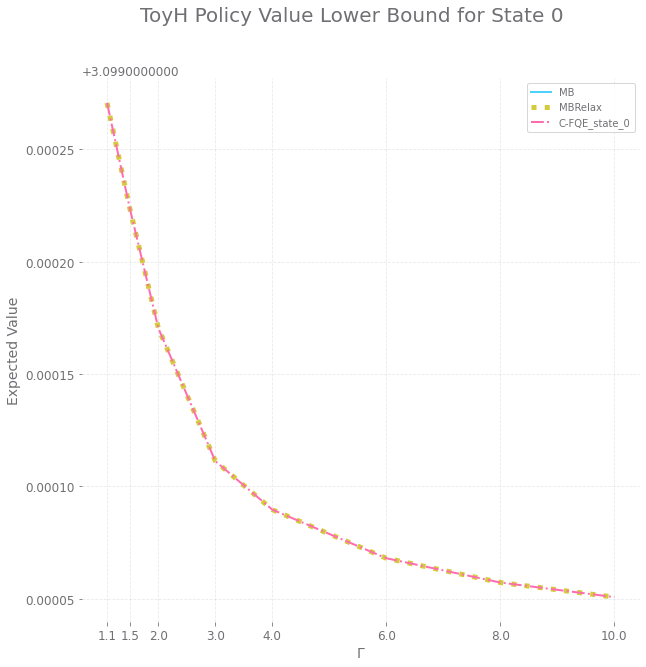

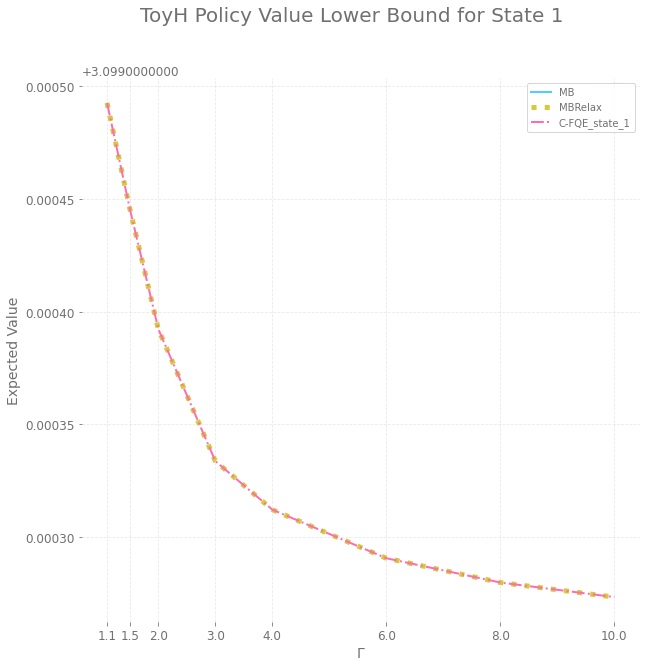

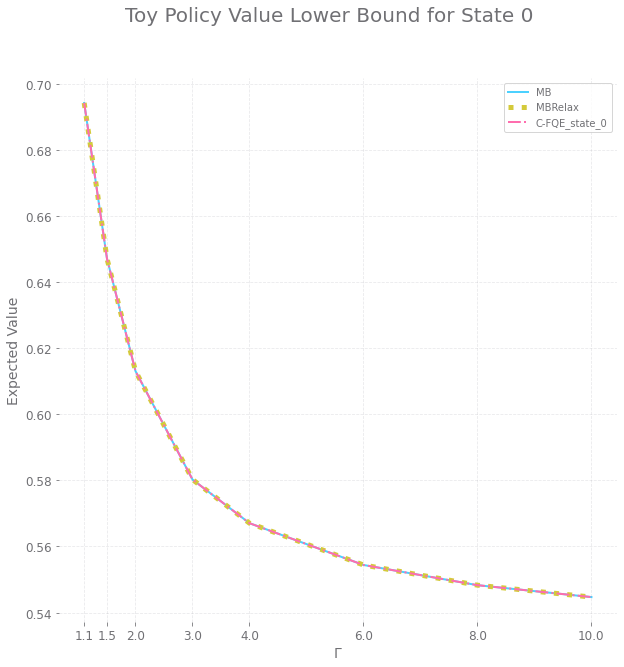

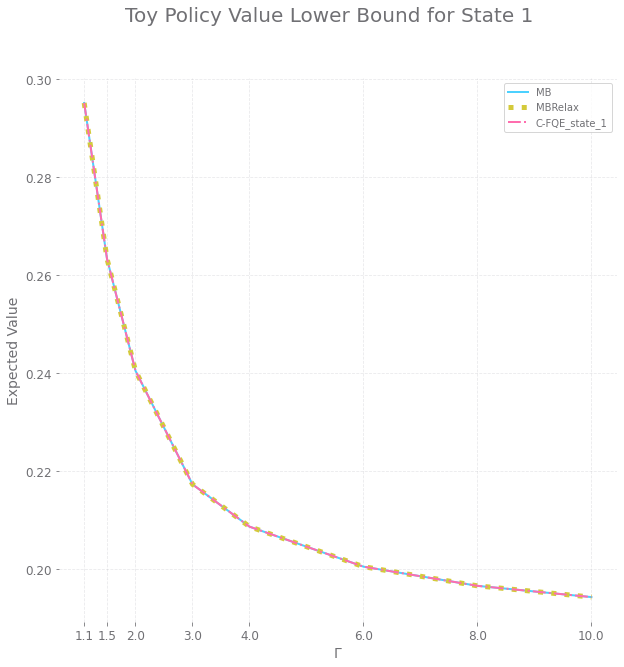

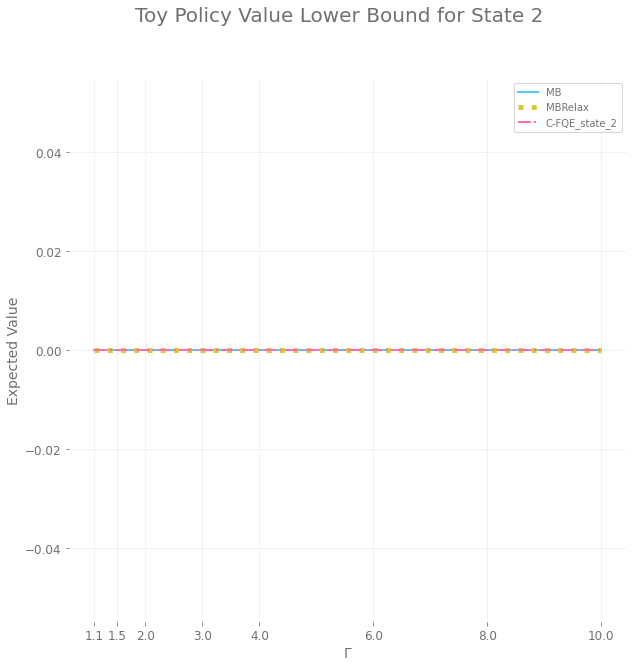

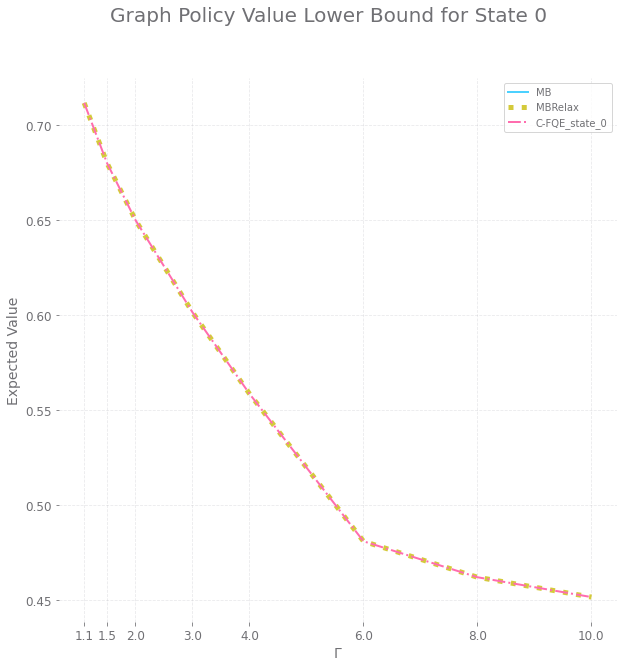

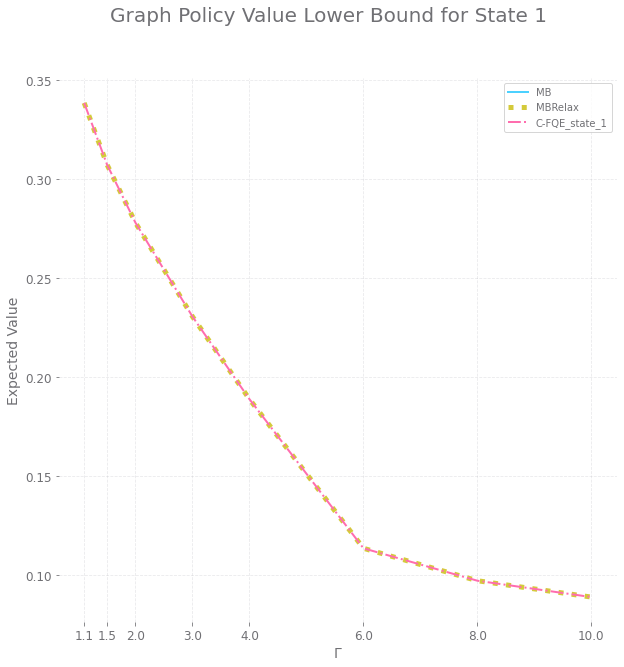

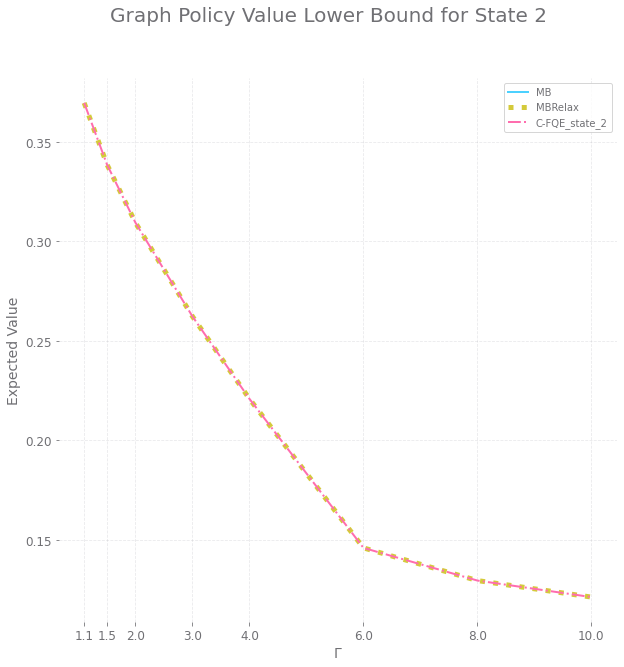

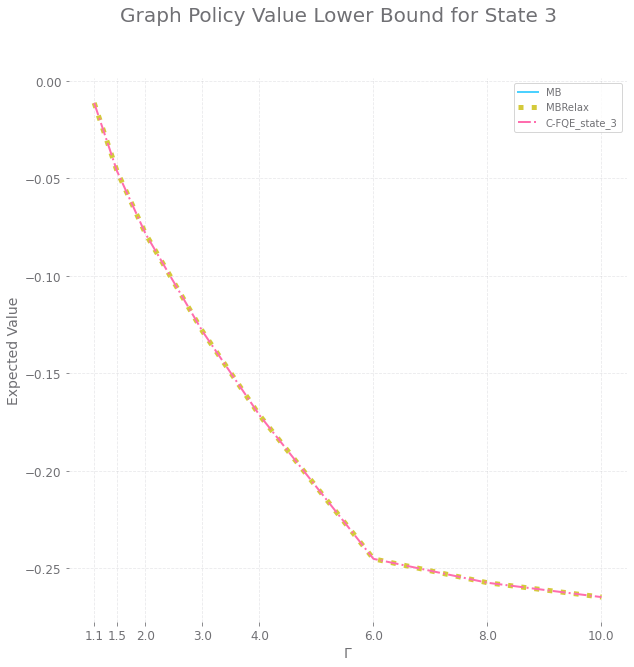

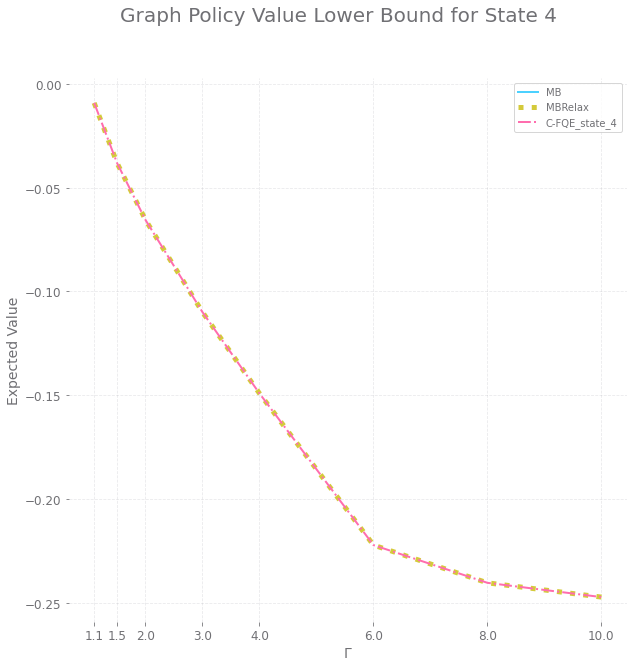

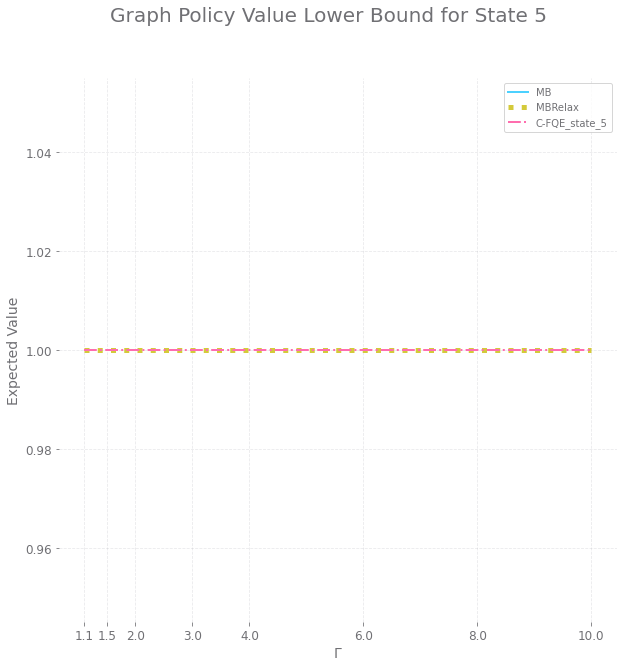

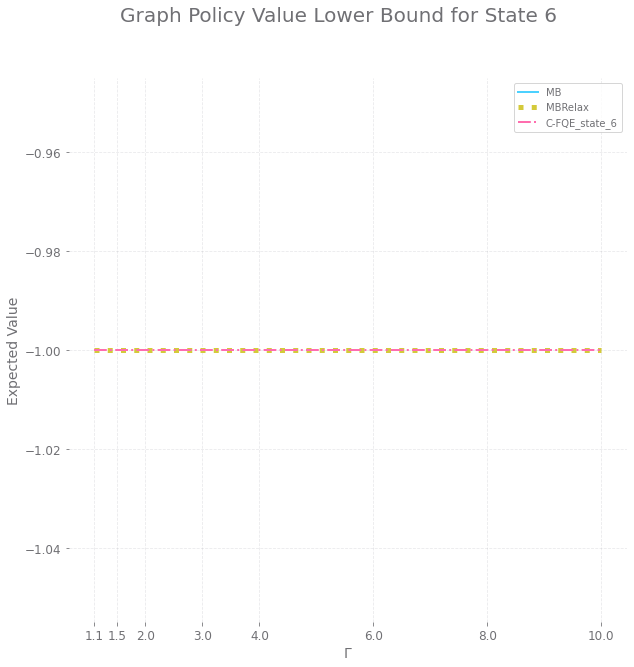

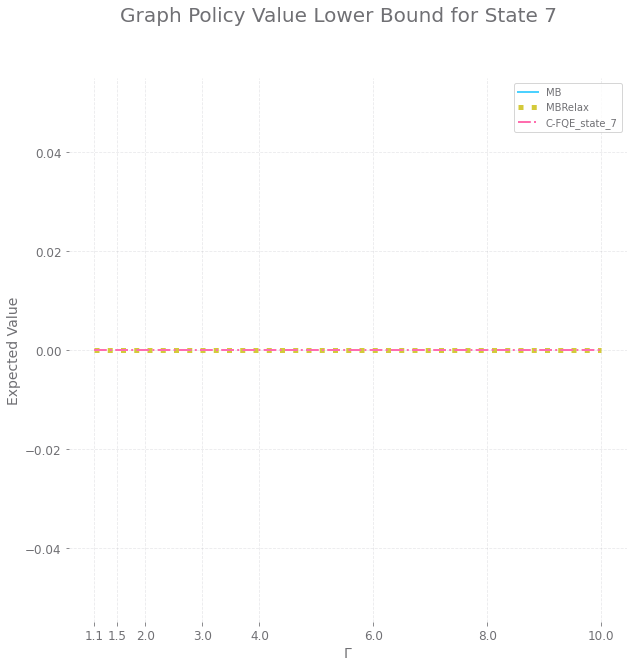

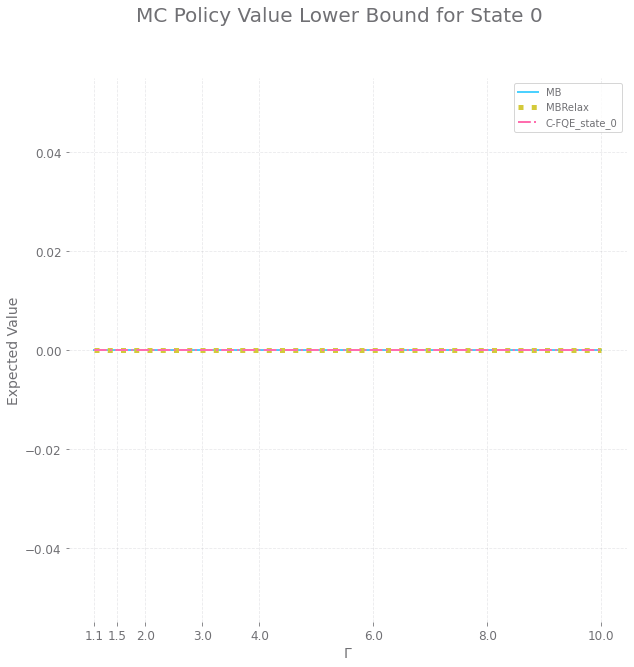

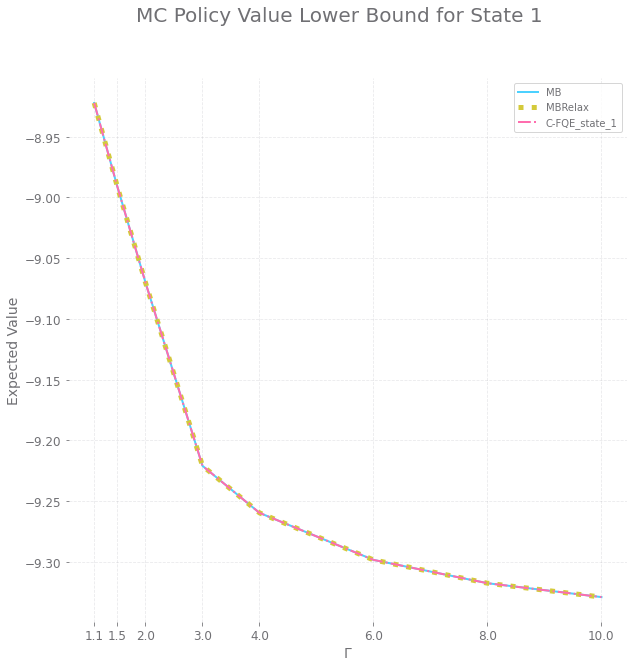

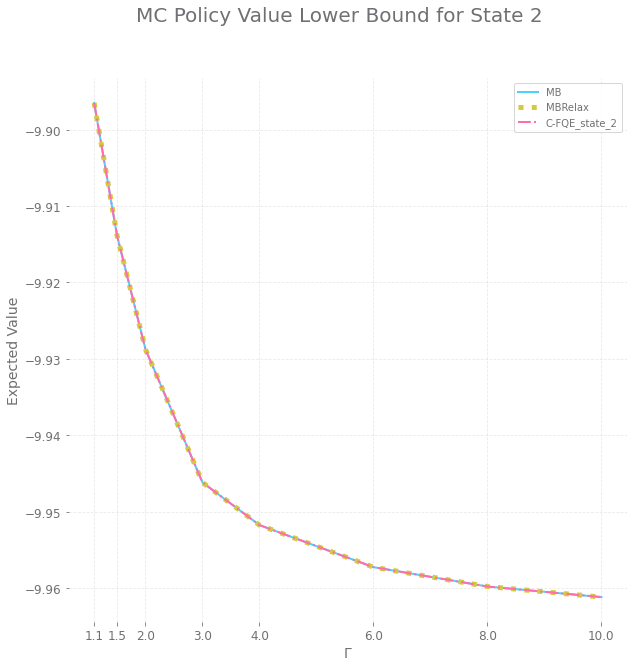

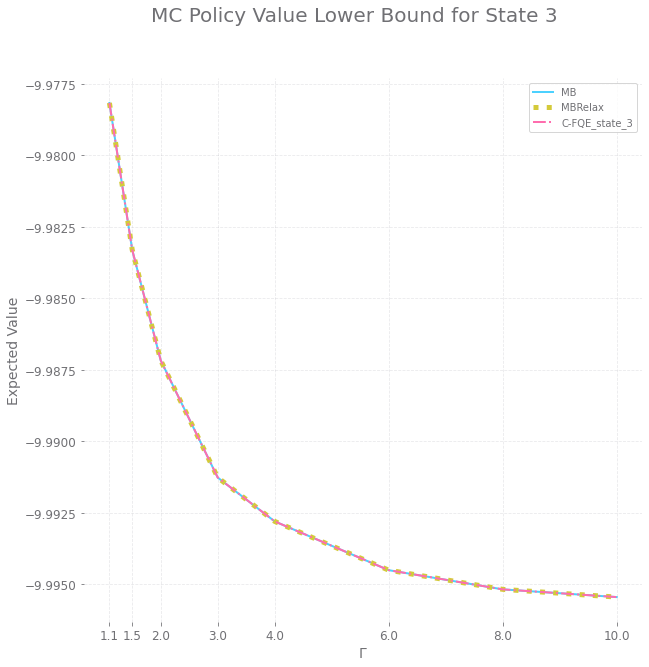

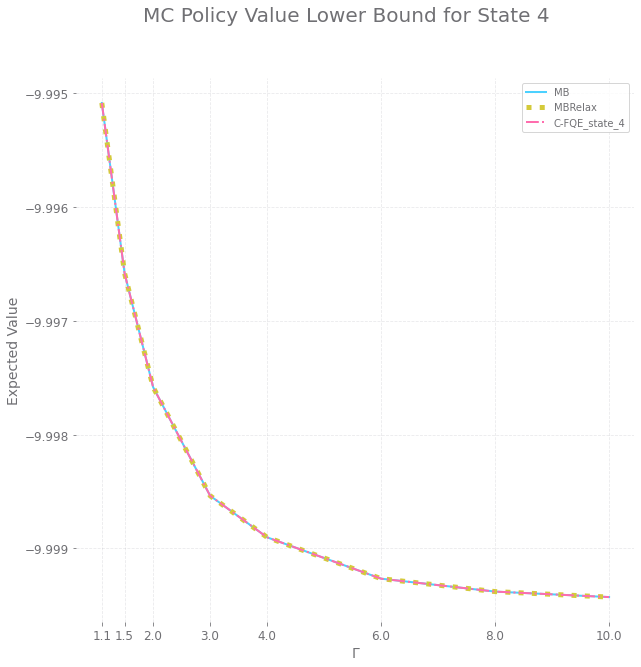

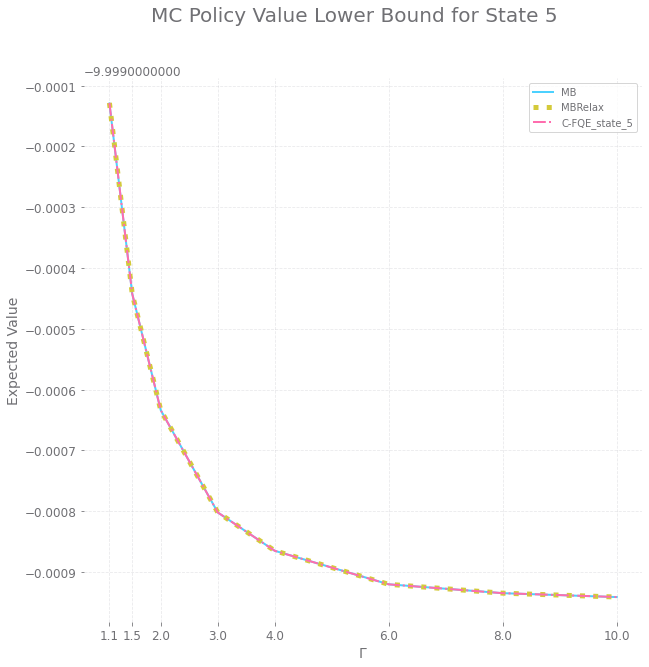

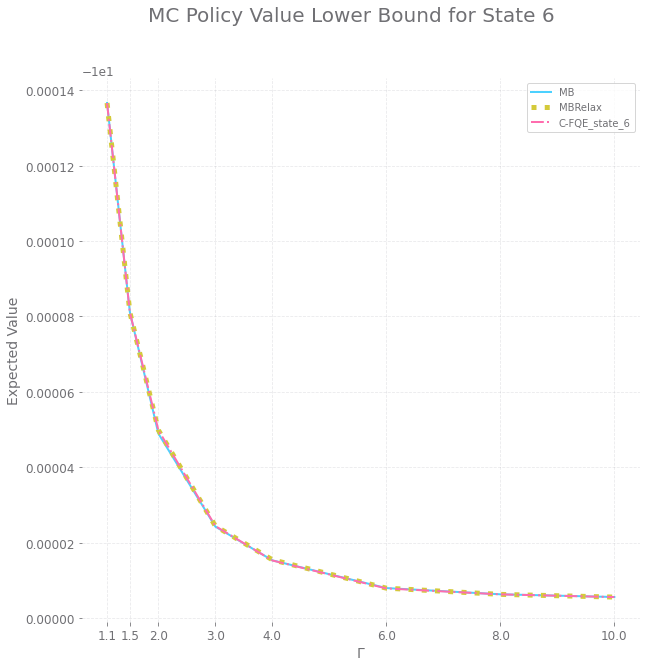

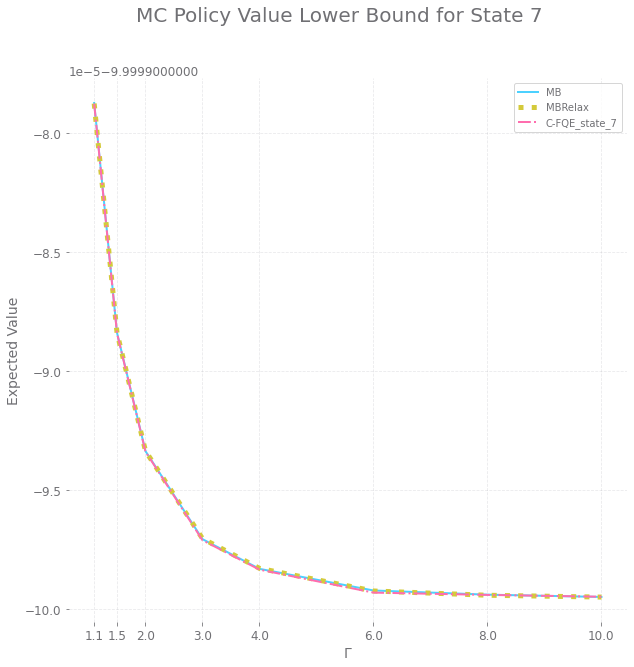

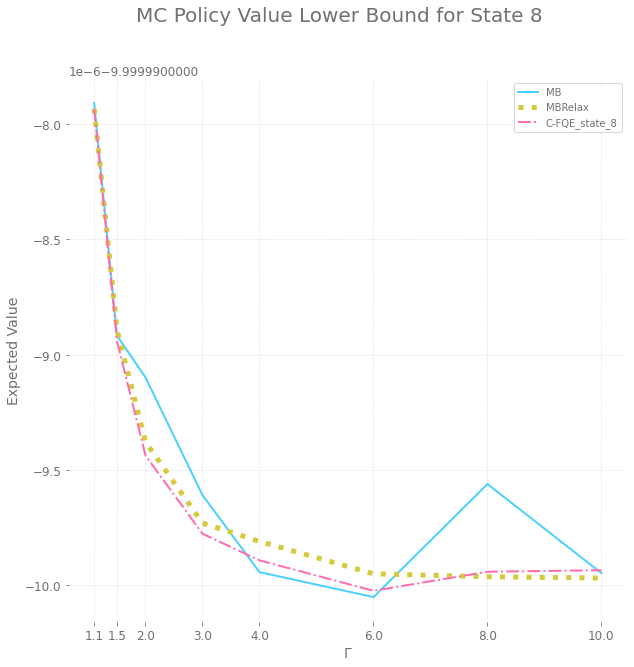

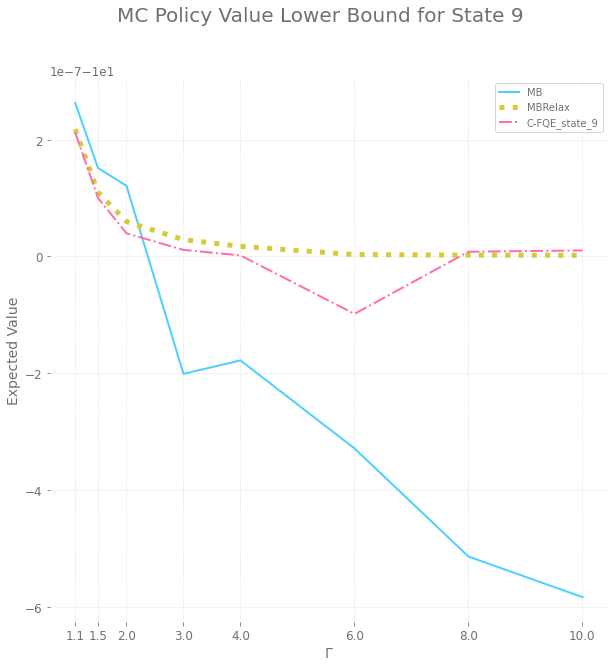

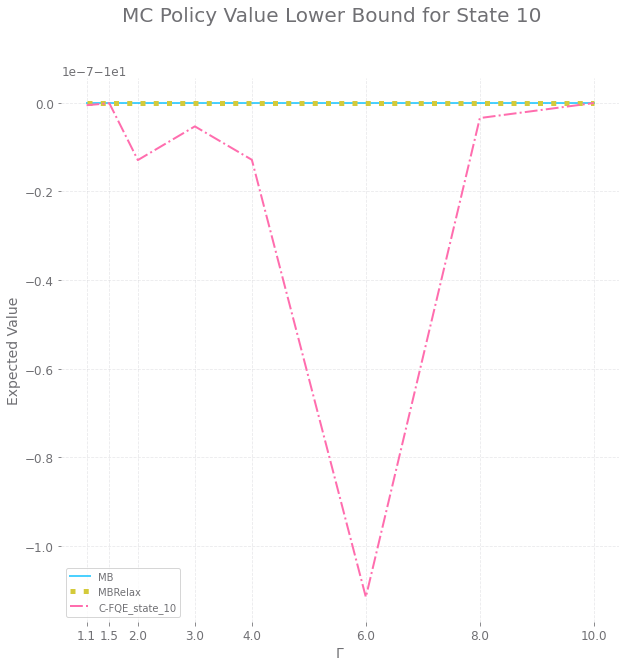

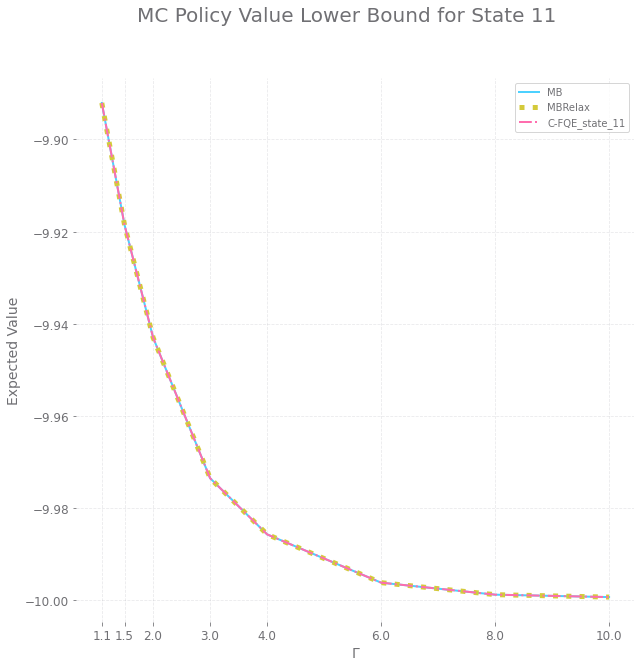

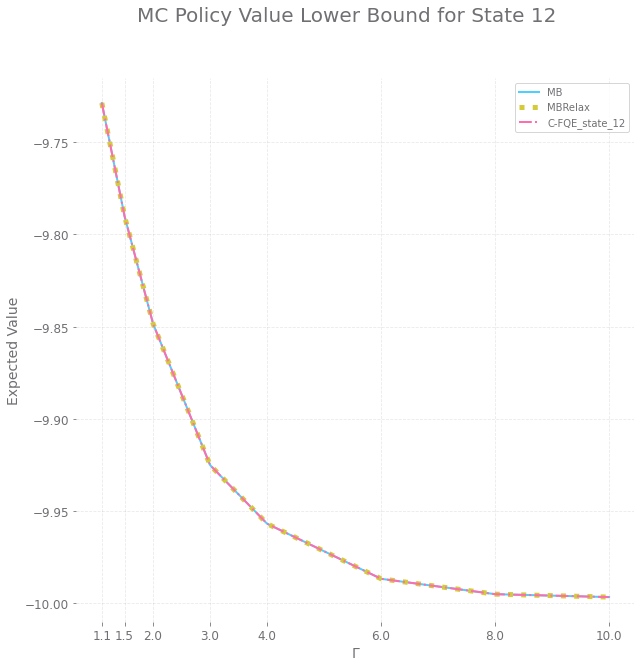

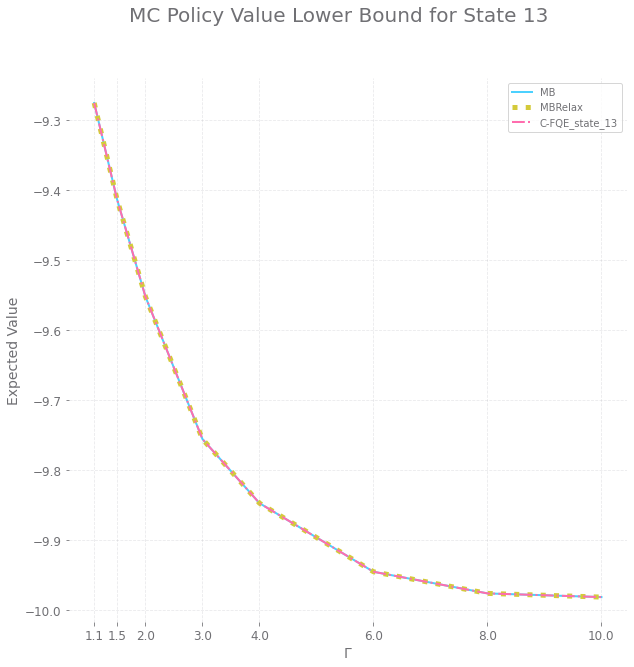

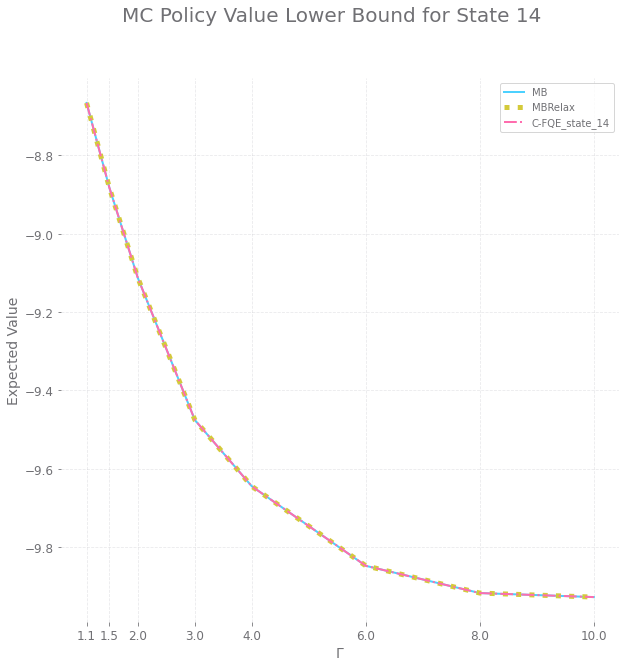

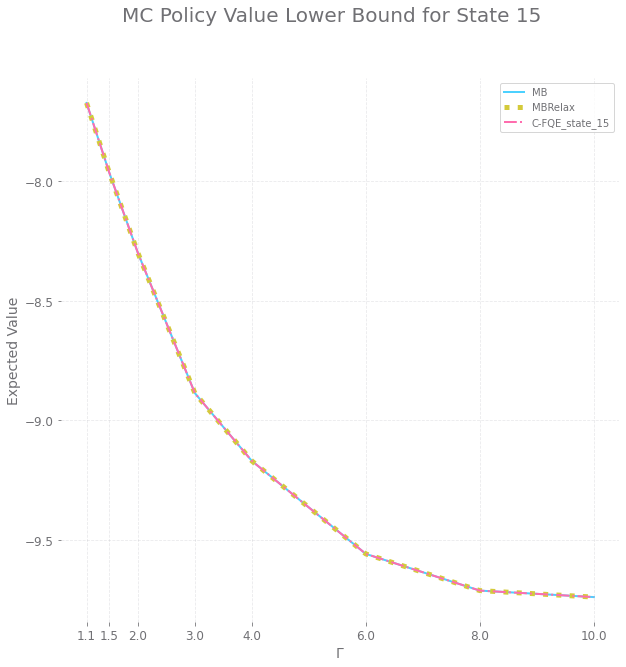

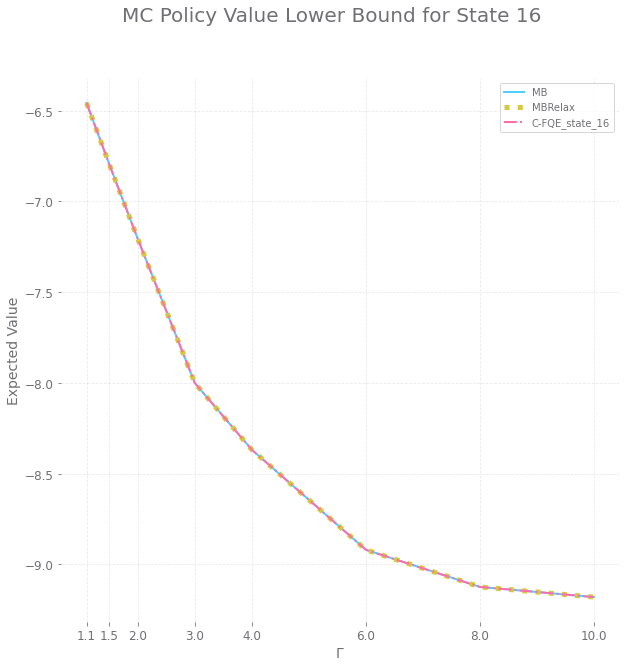

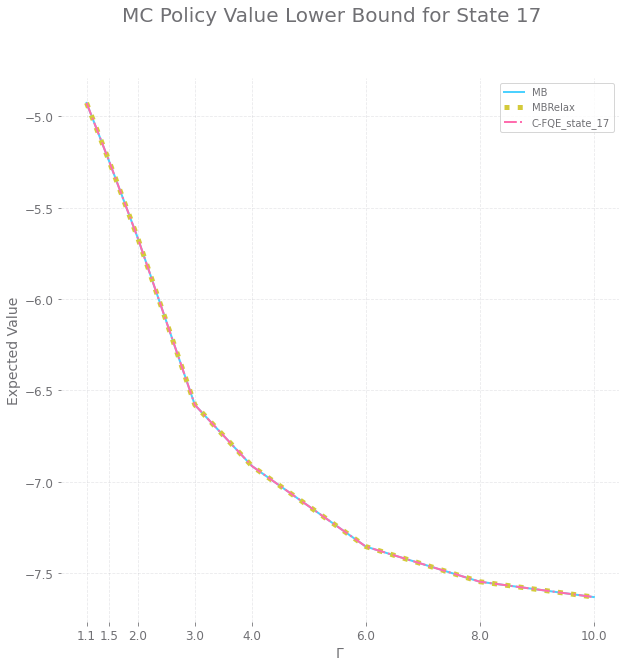

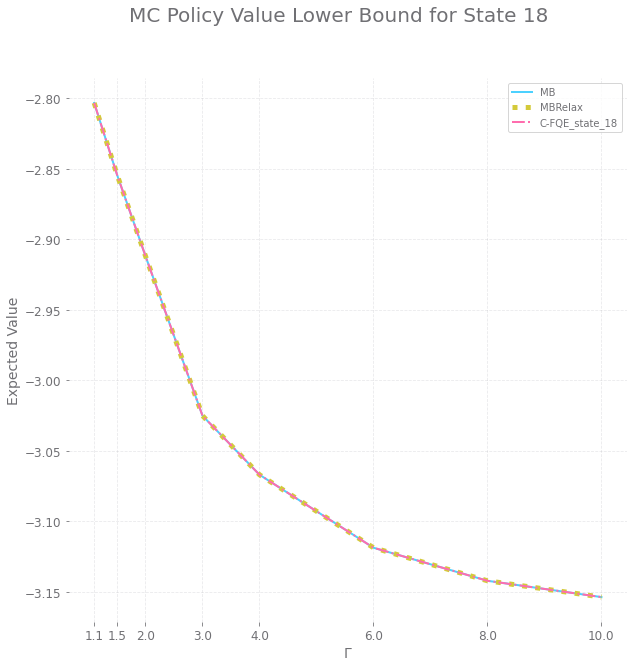

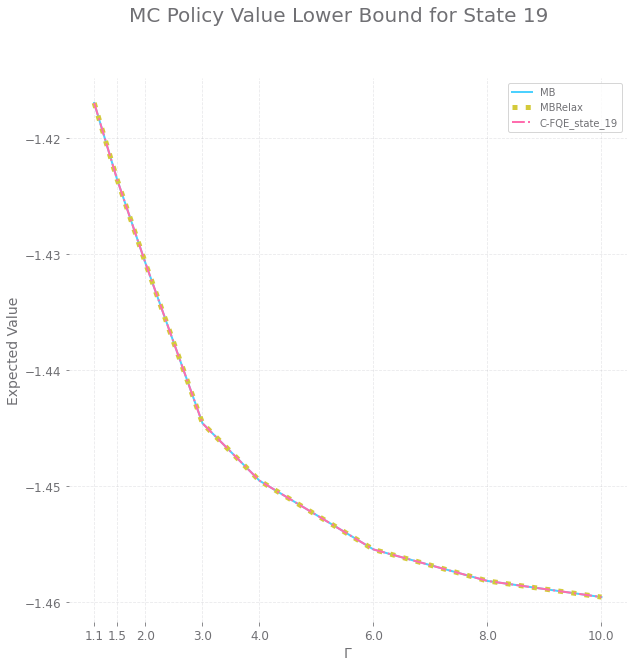

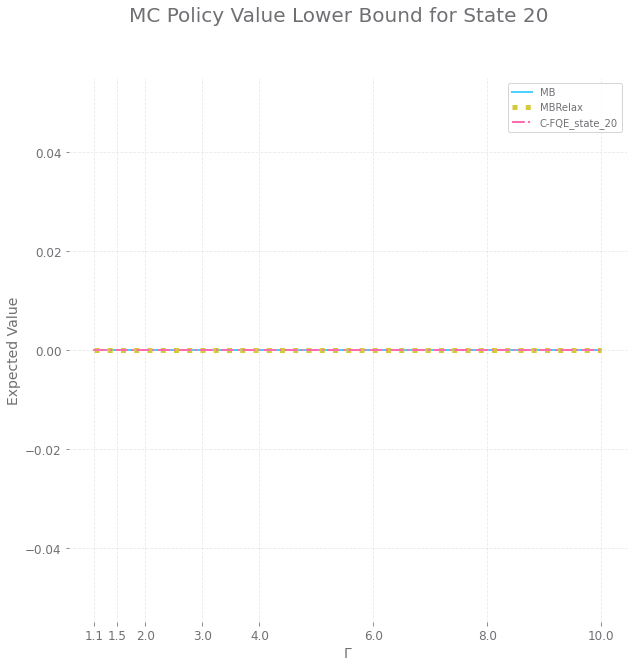

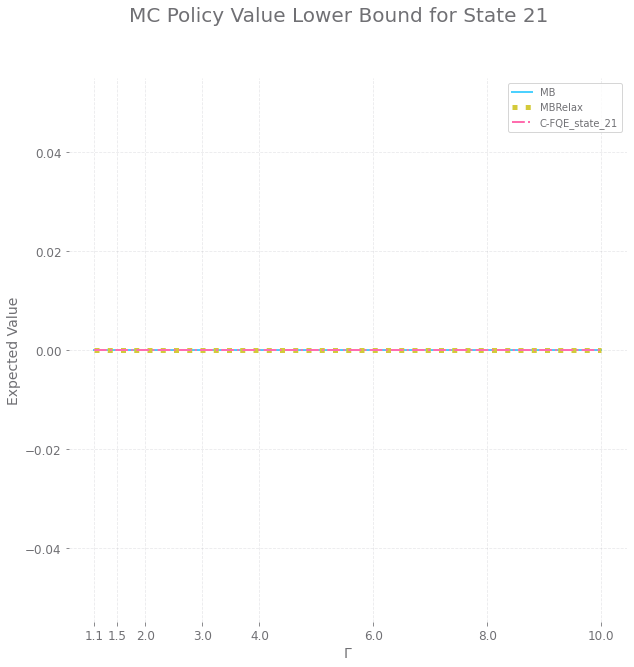

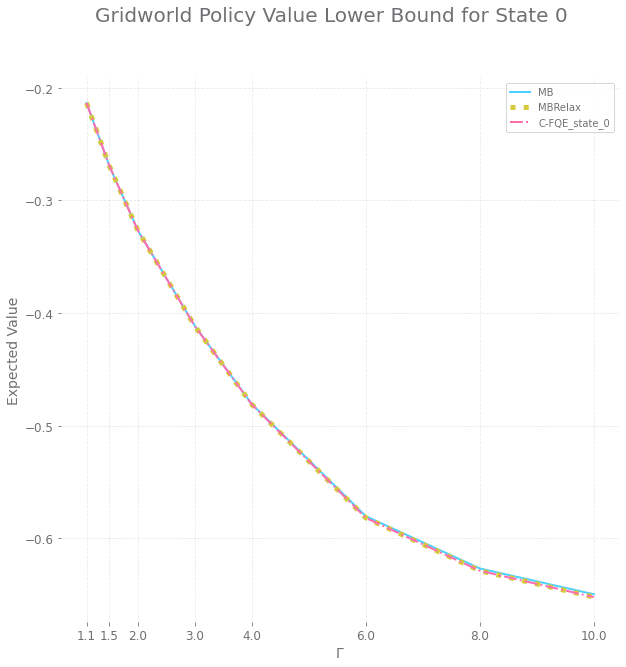

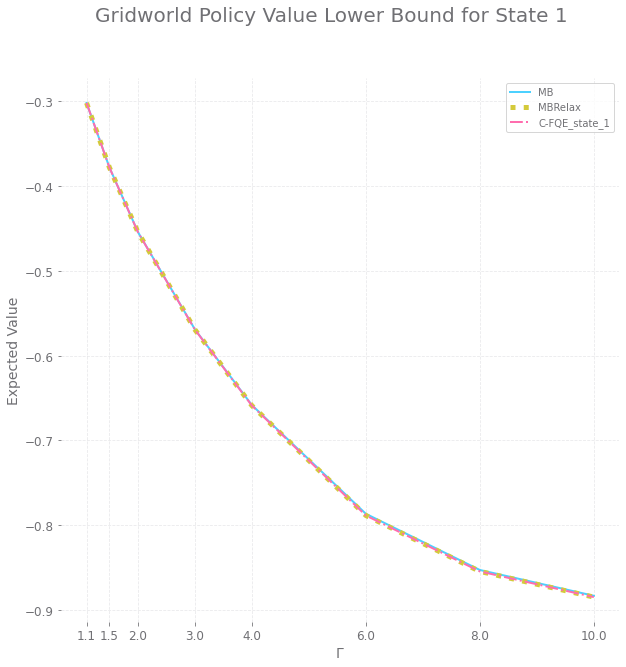

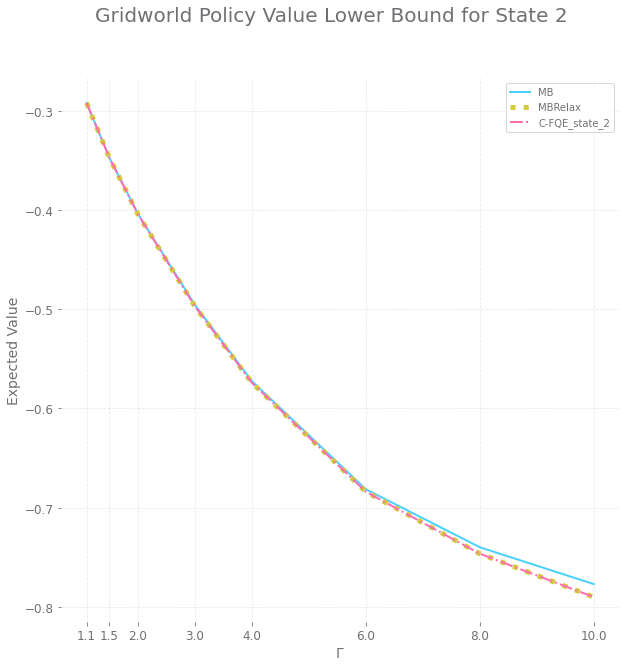

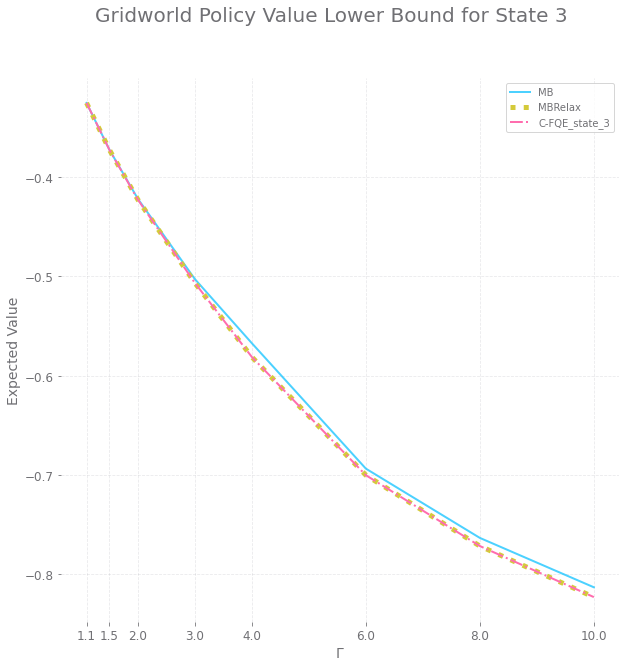

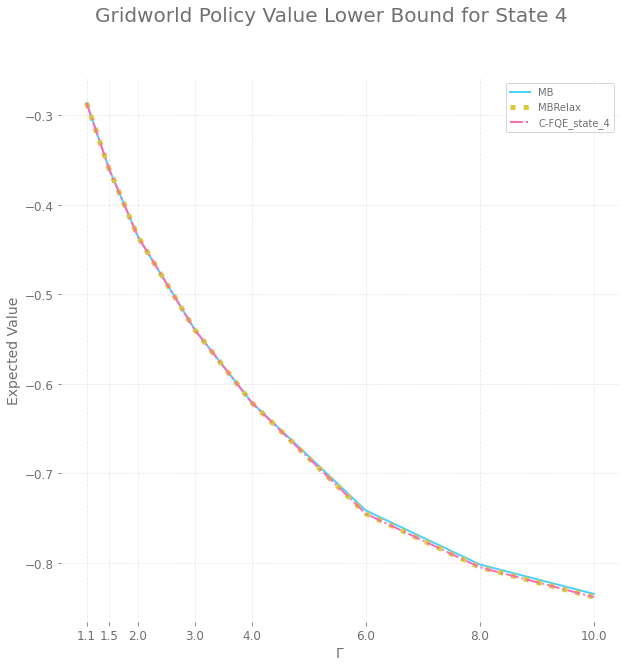

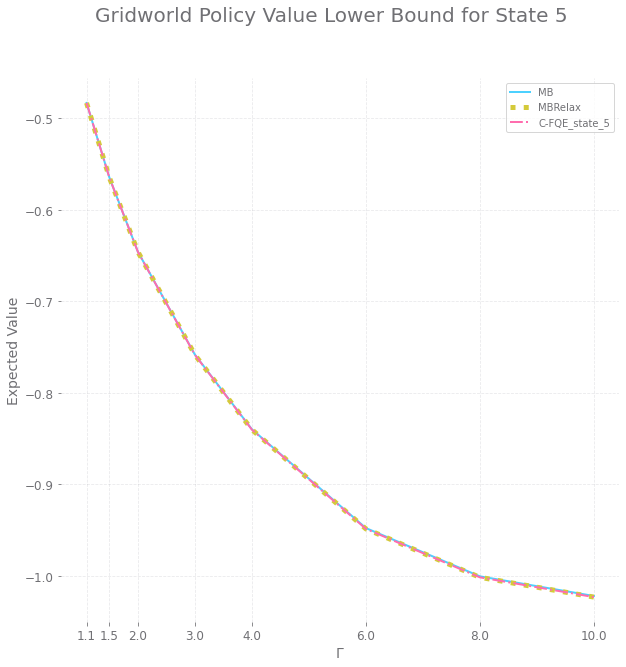

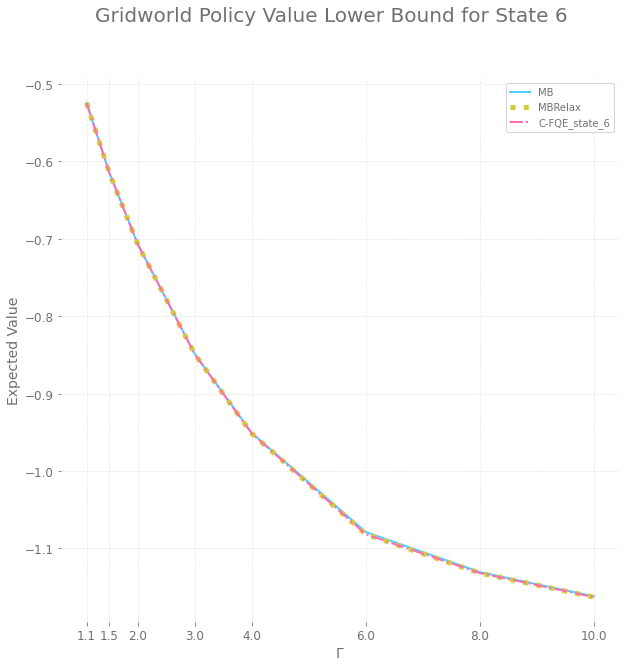

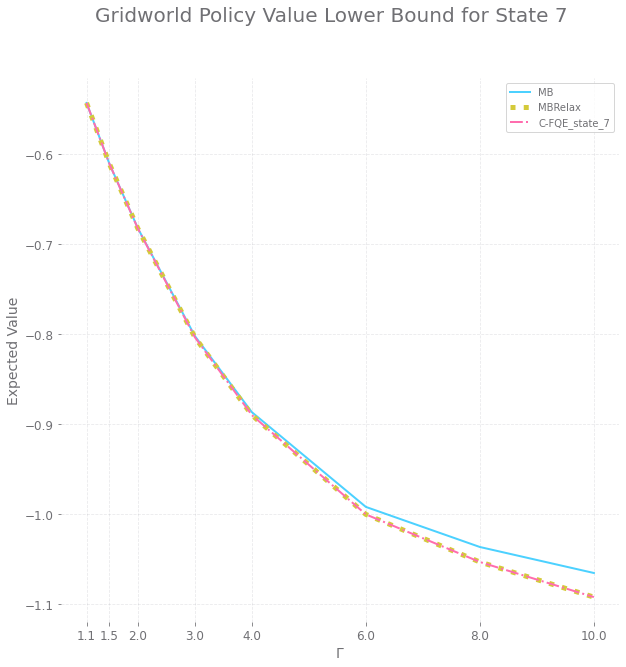

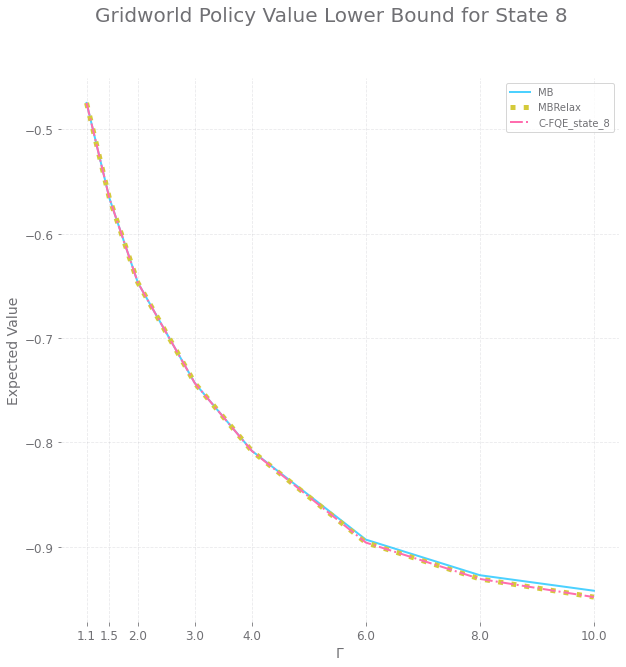

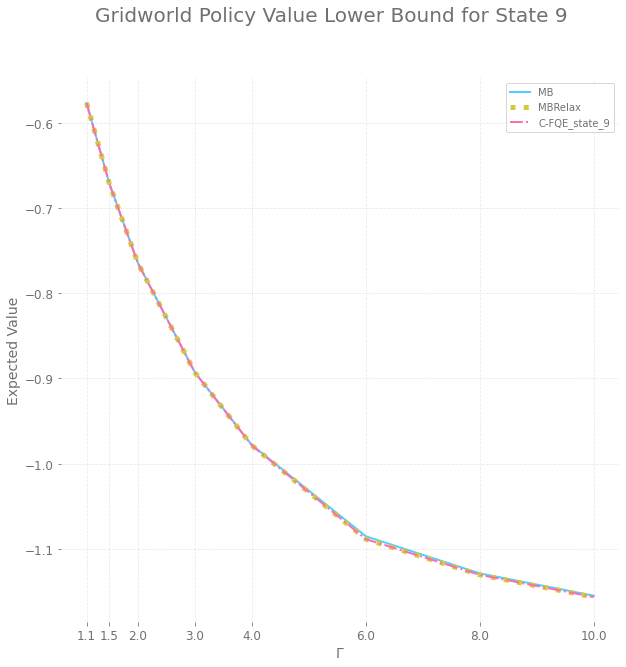

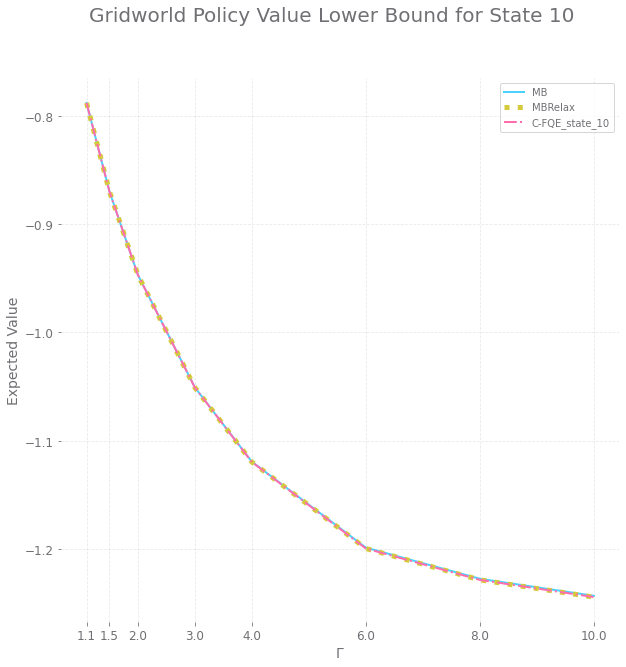

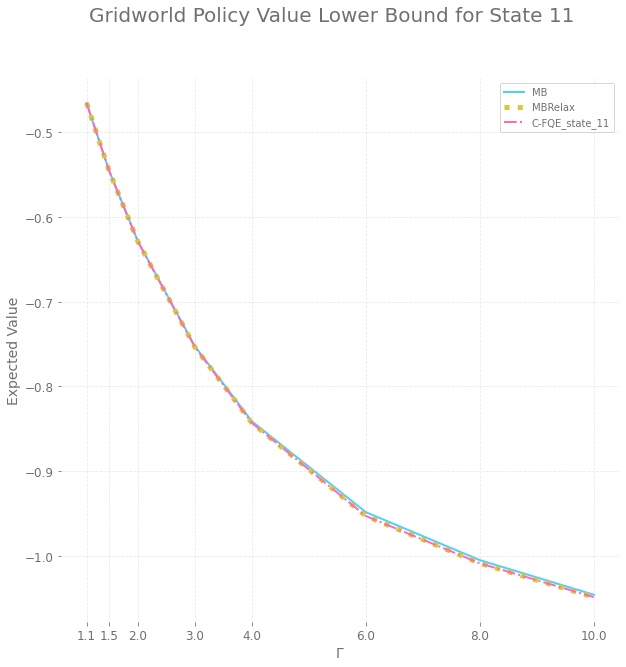

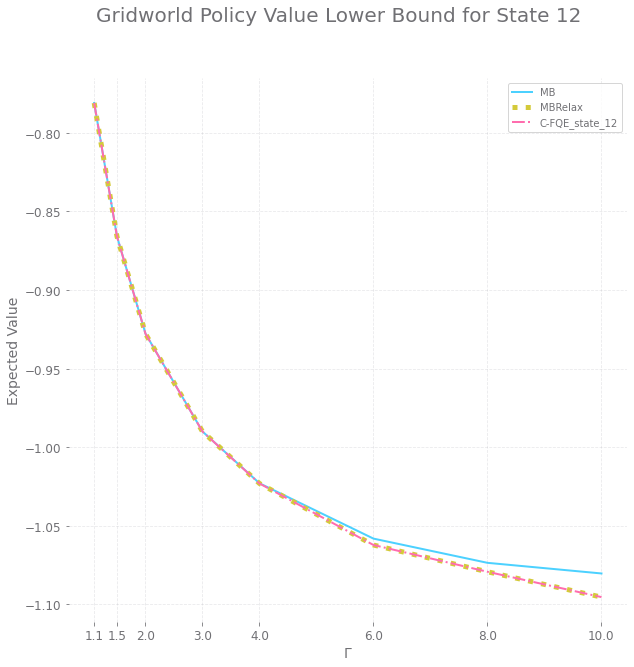

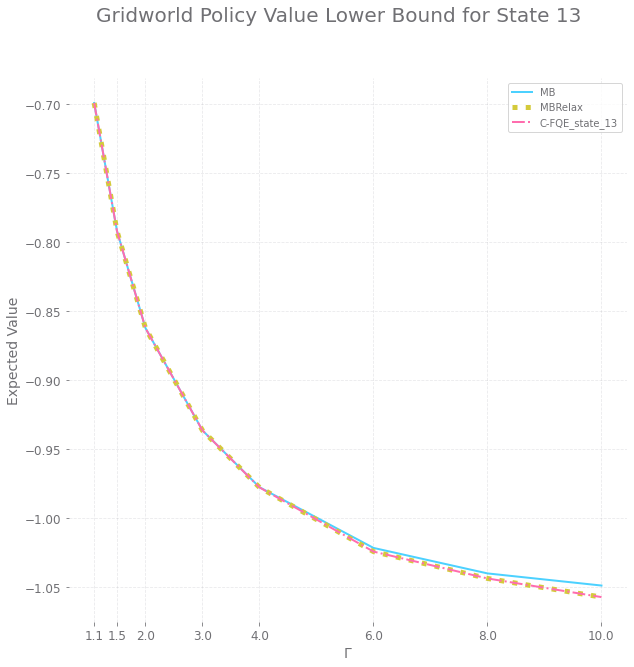

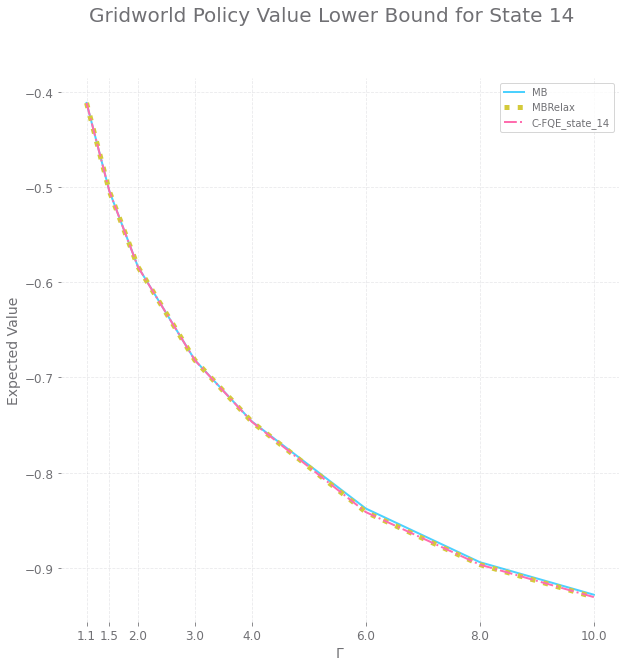

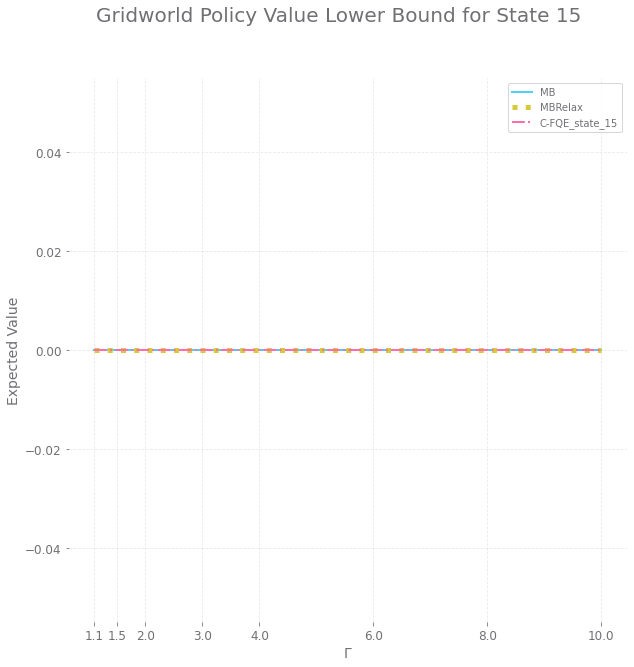

In [28]:
envNames = ['ToyH', 'Toy', 'Graph', 'MC', 'Gridworld']
for idx, env in enumerate(envs):
    mdp, pi_b, pi_e, base_horizon, gamma, nStates, nActions, term, P, R, x_dist, u_dist, gamma = env

    pi_bsa = np.einsum('u,usa->sa', u_dist, pi_b)

    for so in range(nStates):
        #pi_b_val = mdp.get_value(nom_q,pi_bsa)[0][so]
        #pi_e_val = mdp.get_value(nom_q,pi_e)[0][so]

        fig, ax = plt.subplots(figsize=(10,10))
        #change this to R_sa form
        #ax.axhline(pi_e_val, color='green', linestyle='--', label='pi_e_no_cf_state_' + str(so))
        #ax.axhline(pi_b_val, color='red', linestyle='--', label='pi_b')
        ax.set_xticks(gams)
        ax.set_xlabel('$\Gamma$')
        ax.set_ylabel('Expected Value')
        fig.suptitle(envNames[idx] + " " + "Policy Value Lower Bound for State " + str(so), size=20)

        ax.plot(gams, objEnvs[idx][so], label='MB', alpha=0.7)
        ax.plot(gams, relaxEnvs[idx].T[so], label='MBRelax', linewidth=5.0, linestyle='dotted')
        #ax.plot(gams, np.array(fqe_results)[:,so], label='David FQE_state_'+str(so))
        #ax.plot(gams, torchEnvs[idx][so], label='MBGrad', alpha=0.7)
        ax.plot(gams, np.array(cfqeEnvs[idx]).T[so], label='C-FQE_state_'+str(so), linestyle='dashdot')

        ax.legend()
        plt.savefig("plots/"+envNames[idx]+"State"+str(so)+".jpg")

In [72]:
objEnvs[2]

[[inf, inf, inf, inf, inf, inf, inf, inf],
 [inf, inf, inf, inf, inf, inf, inf, inf],
 [inf, inf, inf, inf, inf, inf, inf, inf],
 [inf, inf, inf, inf, inf, inf, inf, inf],
 [inf, inf, inf, inf, inf, inf, inf, inf],
 [inf, inf, inf, inf, inf, inf, inf, inf],
 [inf, inf, inf, inf, inf, inf, inf, inf],
 [inf, inf, inf, inf, inf, inf, inf, inf],
 [inf, inf, inf, inf, inf, inf, inf, inf],
 [inf, inf, inf, inf, inf, inf, inf, inf],
 [inf, inf, inf, inf, inf, inf, inf, inf],
 [inf, inf, inf, inf, inf, inf, inf, inf],
 [inf, inf, inf, inf, inf, inf, inf, inf],
 [inf, inf, inf, inf, inf, inf, inf, inf],
 [inf, inf, inf, inf, inf, inf, inf, inf],
 [inf, inf, inf, inf, inf, inf, inf, inf],
 [inf, inf, inf, inf, inf, inf, inf, inf],
 [inf, inf, inf, inf, inf, inf, inf, inf],
 [inf, inf, inf, inf, inf, inf, inf, inf],
 [inf, inf, inf, inf, inf, inf, inf, inf],
 [inf, inf, inf, inf, inf, inf, inf, inf],
 [inf, inf, inf, inf, inf, inf, inf, inf]]

## More of David's Code

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import pickle

pickle.dump( fqe_envs, open( "fqe_horizon_experiments.p", "wb" ) )
pickle.dump( mb_envs, open( "mb_horizon_experiments.p", "wb" ) )

In [ ]:
#fqe_envs = pickle.load( open( "fqe_horizon_experiments.p", "rb" ) )
#mb_envs = pickle.load( open( "mb_horizon_experiments.p", "rb" ) )

In [ ]:
# select only base horizon
#fqe_envs = fqe_envs[::3]
#mb_envs = mb_envs[::3]
fqe_envs = feq_envs[0]
mb_envs = mb_envs[0]

In [ ]:
pi_e_vals = [0.499015492905087 , 0.7174129322887378, -15.738140536232656, -0.35692764811666317]
pi_b_vals = [0.33965256189333337 , -0.178639828, -18.189038465627075, -0.49942501436258074]

In [35]:
len(relaxEnvs)

4

In [ ]:
from matplotlib import colors

import matplotlib
matplotlib.rcParams.update({'font.size': 18})

gams = [1.1, 1.5, 2, 3, 4, 6, 8, 10]
nGams = len(gams)

Pbs = [1.1, 1.5, 2, 3, 4, 6, 8, 10]
nPbs = len(Pbs)

Pbs_ext = np.insert(Pbs,0,0)

deltacol = np.flip(plt.cm.plasma(Pbs_ext / np.amax(Pbs) ), axis=0)

count = 0
envTitles = ["toy", "ope-graph", 'ope-mc', 'ope-gridworld']
for fqe_results, mb_results in zip(fqe_envs,mb_envs):
    fig = plt.figure()
    fig.set_size_inches(7.5, 7)
    plt.plot(gams,fqe_results, color='k')
    for p in range(nPbs):
        plt.plot(gams, mb_results[:,p], color=deltacol[p+1], label="{:.1f}".format(Pbs[p]))
    plt.axhline(pi_e_vals[count], color='green', linestyle='--')
    plt.axhline(pi_b_vals[count], color='red', linestyle='--')
    plt.ylabel("Expected Value")
    plt.xlabel("$\Gamma$")
    plt.xlim([1,10])
    plt.title(envTitles[count])
    plt.grid()
    plt.tight_layout()
    #fig.savefig("cam_ready_lower_bound_plot_%s.pdf" % count)
    count += 1